# Dog Inpainting
Uczenie Głębokie - praca domowa<br />
Autorzy:<br />
*Jakub Link 184469*<br />
*Michał Cellmer 184685*<br />
specjalność: Uczenie Maszynowe<br />


In [1]:
import cv2
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

## Pozyskanie danych

In [ ]:
cache_path = kagglehub.dataset_download("wutheringwang/dog-face-recognition")
shutil.move(cache_path, "archive")

## Konfiguracja parametrów

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 64
batch_size = 32
epochs = 20
learning_rate = 1e-3
mask_fraction_range = (0.15, 0.3)

data_dir = "./archive"

## Przetwarzanie wstępne

In [3]:
class DogDataset(Dataset):
    def __init__(self, root_dir):
        self.image_files = []
        for root, _, files in os.walk(root_dir):
            self.image_files.extend([os.path.join(root, f) for f in files if f.endswith('.jpg')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (image_size, image_size))
        image = image.astype(np.float32) / 255.0

        # Mask generation
        mask = np.zeros((image_size, image_size), dtype=np.float32)
        mask_fraction = np.random.uniform(*mask_fraction_range)
        mask_size = int(image_size * mask_fraction)
        top = np.random.randint(0, image_size - mask_size)
        left = np.random.randint(0, image_size - mask_size)
        mask[top:top + mask_size, left:left + mask_size] = 1

        masked_image = image * (1 - mask)
        return (
            torch.tensor(masked_image).unsqueeze(0),
            torch.tensor(image).unsqueeze(0),
            torch.tensor(mask).unsqueeze(0)
        )

In [4]:
train_dataset = DogDataset(os.path.join(data_dir, "train"))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DogDataset(os.path.join(data_dir, "test_200_single_img"))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Definicja modelu autokodera

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
model = Autoencoder().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Trening

In [7]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for masked_images, original_images, masks in tqdm(train_loader):
        masked_images = masked_images.to(device)
        original_images = original_images.to(device)
        masks = masks.to(device)

        outputs = model(masked_images)
        loss = loss_fn(outputs * masks, original_images * masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

100%|██████████| 571/571 [00:17<00:00, 33.07it/s]


Epoch [1/20], Loss: 0.0010


100%|██████████| 571/571 [00:16<00:00, 34.75it/s]


Epoch [2/20], Loss: 0.0007


100%|██████████| 571/571 [00:16<00:00, 35.12it/s]


Epoch [3/20], Loss: 0.0007


100%|██████████| 571/571 [00:15<00:00, 35.81it/s]


Epoch [4/20], Loss: 0.0007


100%|██████████| 571/571 [00:16<00:00, 35.24it/s]


Epoch [5/20], Loss: 0.0006


100%|██████████| 571/571 [00:15<00:00, 36.04it/s]


Epoch [6/20], Loss: 0.0006


100%|██████████| 571/571 [00:16<00:00, 35.44it/s]


Epoch [7/20], Loss: 0.0006


100%|██████████| 571/571 [00:16<00:00, 35.16it/s]


Epoch [8/20], Loss: 0.0006


100%|██████████| 571/571 [00:16<00:00, 35.29it/s]


Epoch [9/20], Loss: 0.0006


100%|██████████| 571/571 [00:16<00:00, 34.75it/s]


Epoch [10/20], Loss: 0.0006


100%|██████████| 571/571 [00:16<00:00, 35.56it/s]


Epoch [11/20], Loss: 0.0006


100%|██████████| 571/571 [00:16<00:00, 35.60it/s]


Epoch [12/20], Loss: 0.0006


100%|██████████| 571/571 [00:16<00:00, 34.89it/s]


Epoch [13/20], Loss: 0.0006


100%|██████████| 571/571 [00:15<00:00, 35.80it/s]


Epoch [14/20], Loss: 0.0006


100%|██████████| 571/571 [00:15<00:00, 35.70it/s]


Epoch [15/20], Loss: 0.0005


100%|██████████| 571/571 [00:16<00:00, 34.49it/s]


Epoch [16/20], Loss: 0.0006


100%|██████████| 571/571 [00:16<00:00, 35.21it/s]


Epoch [17/20], Loss: 0.0005


100%|██████████| 571/571 [00:16<00:00, 35.41it/s]


Epoch [18/20], Loss: 0.0005


100%|██████████| 571/571 [00:16<00:00, 35.10it/s]


Epoch [19/20], Loss: 0.0005


100%|██████████| 571/571 [00:16<00:00, 35.06it/s]

Epoch [20/20], Loss: 0.0005


## Ewaluacja

In [8]:
def inpaint_image(model, image, mask):
    model.eval()
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        inpainted_image = output.squeeze(0).cpu()
        result = image * (1 - mask) + inpainted_image * mask
        return result

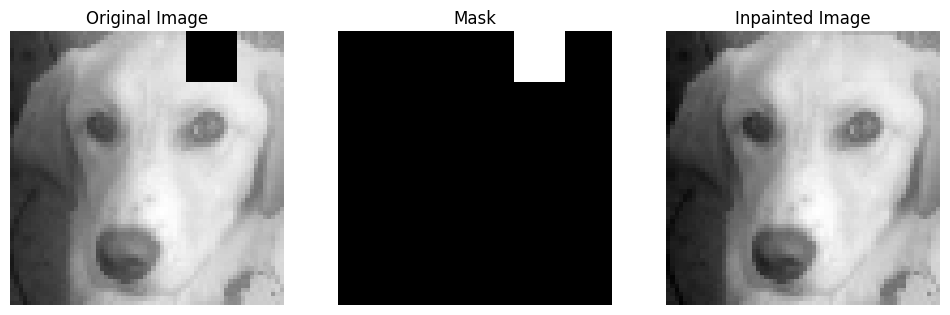

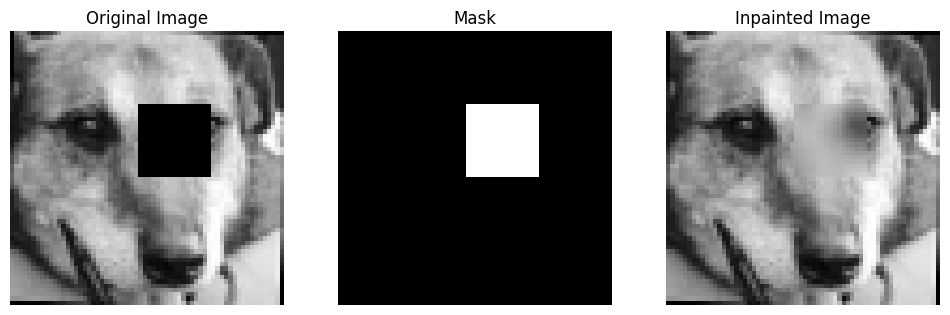

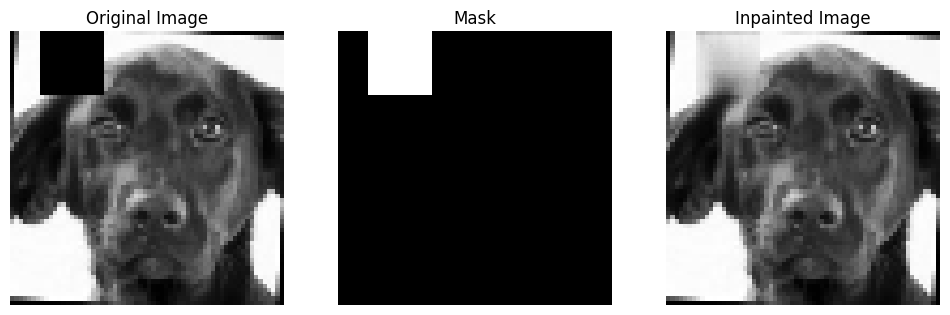

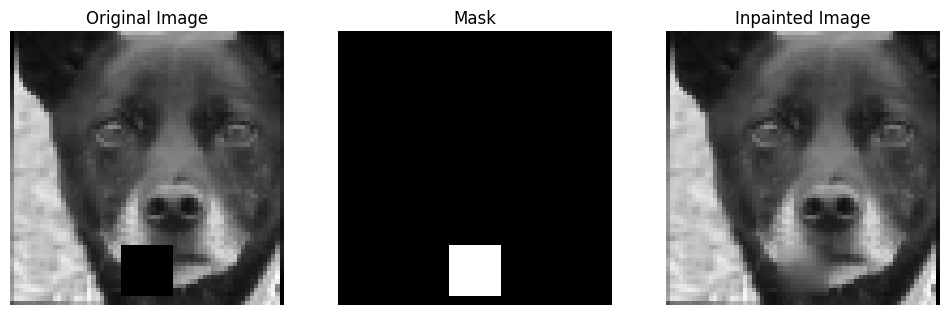

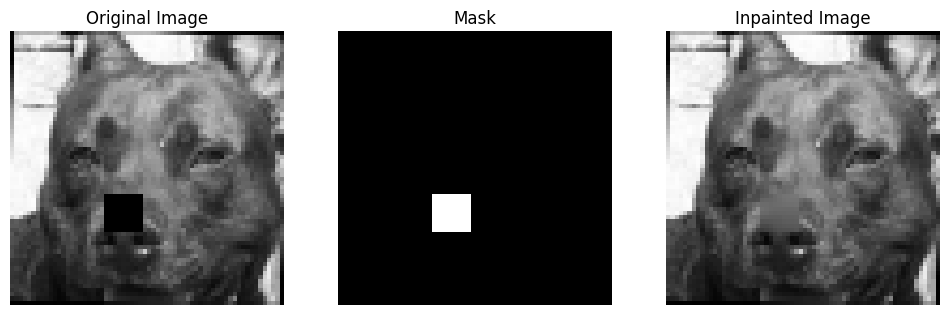

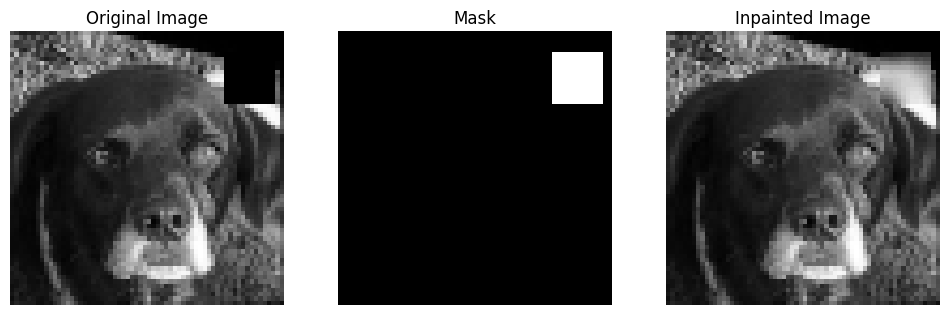

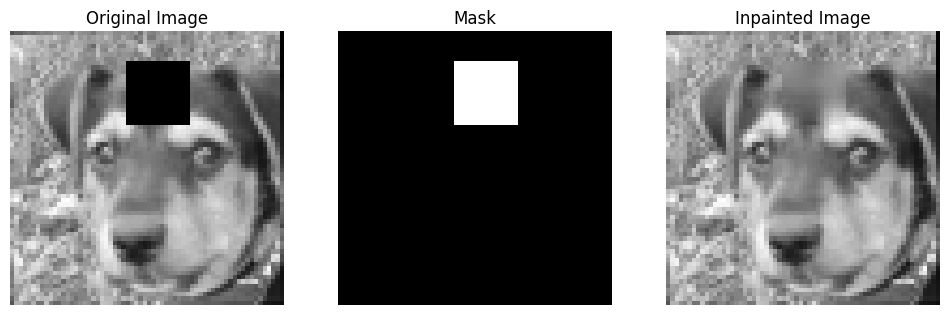

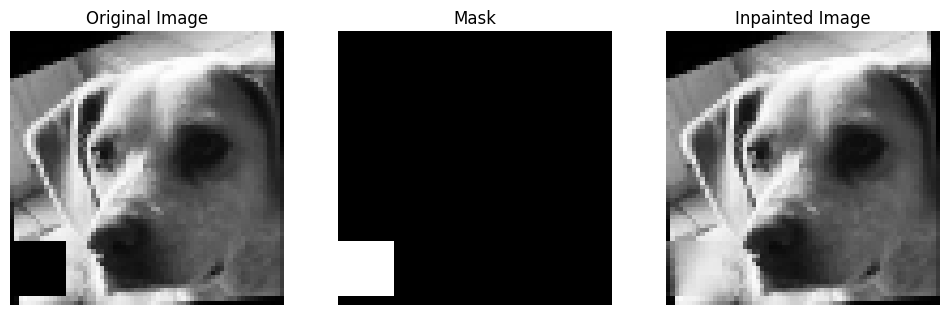

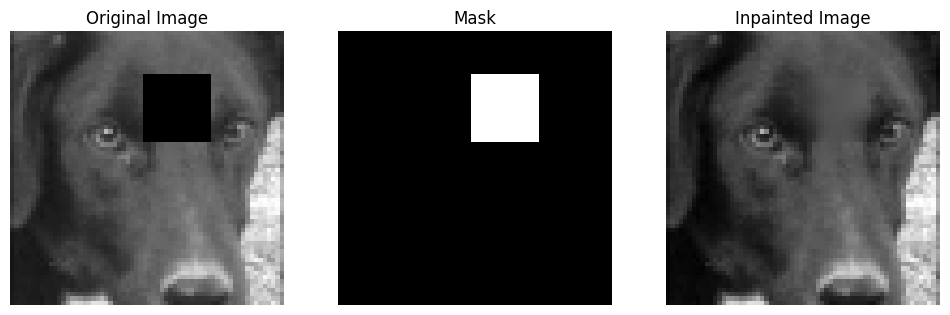

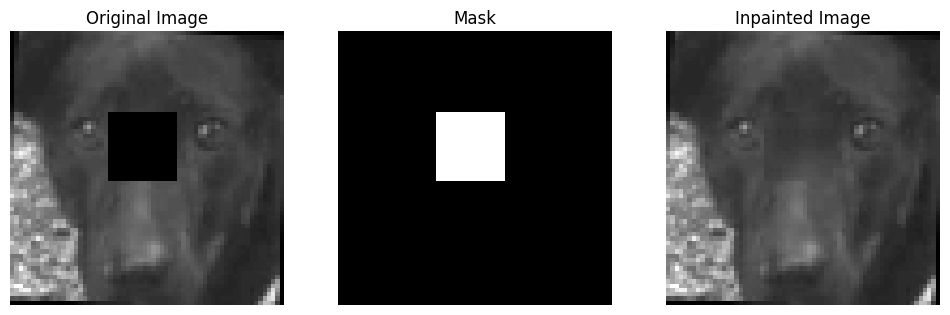

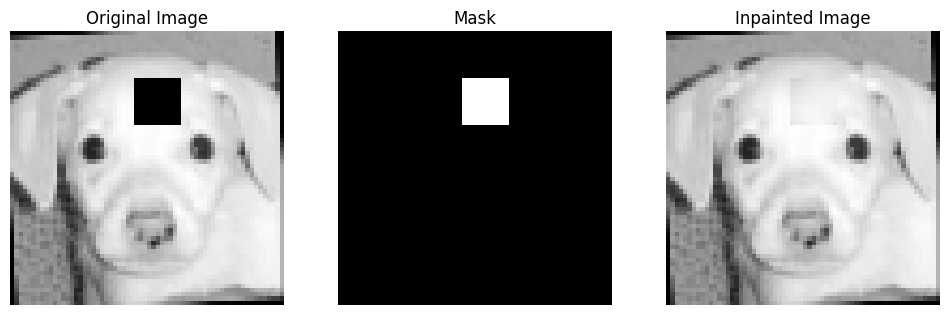

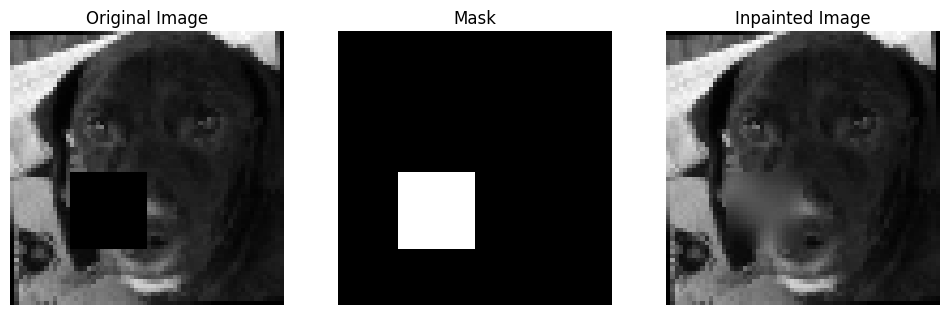

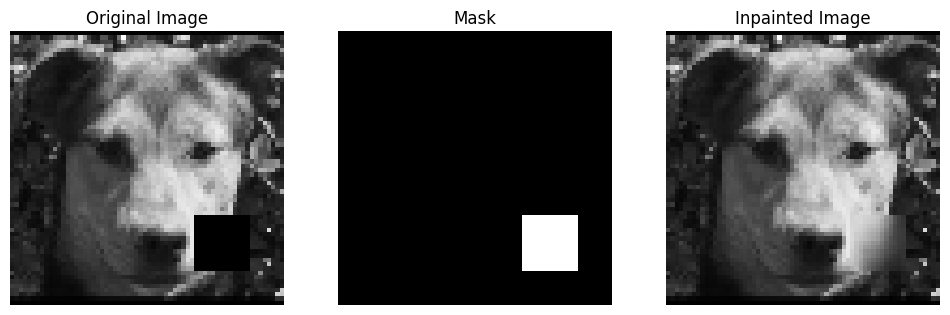

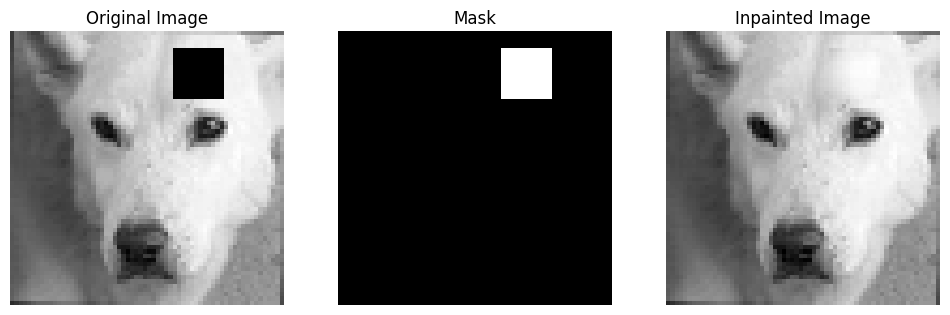

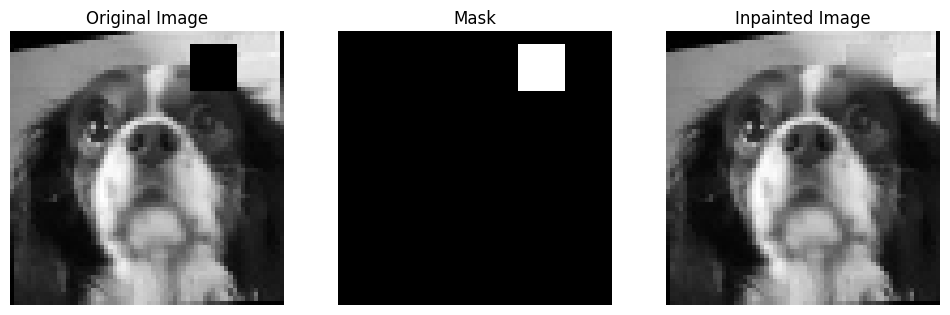

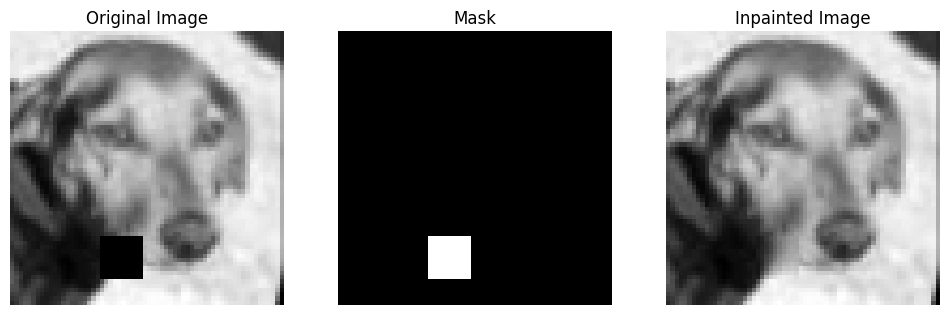

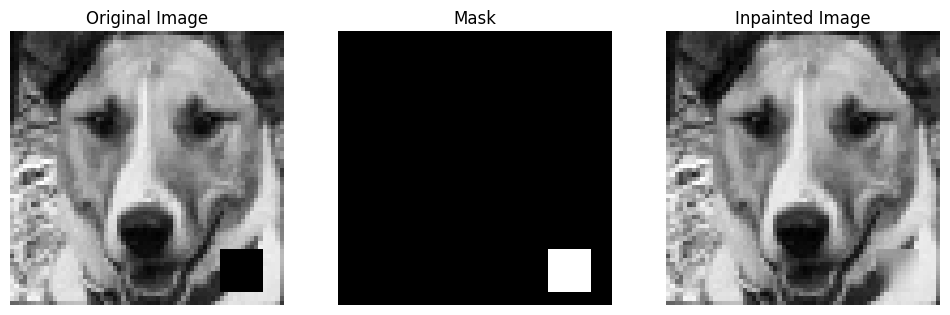

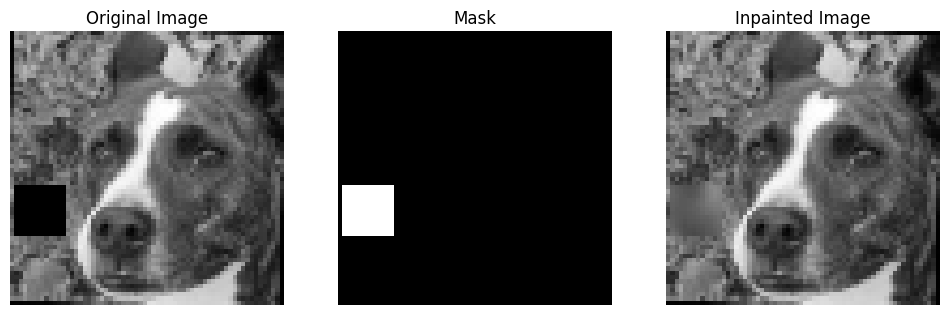

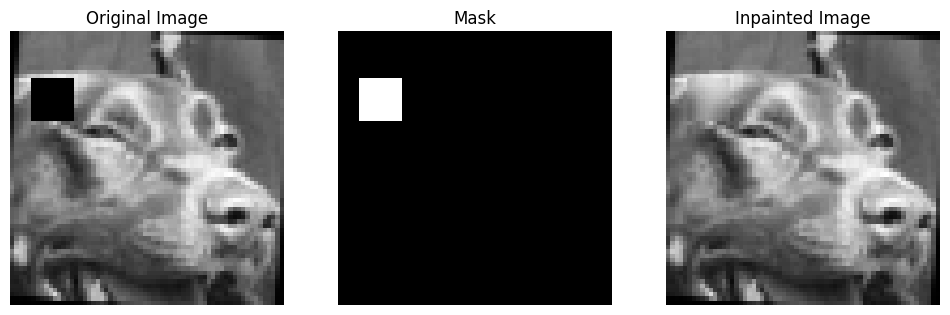

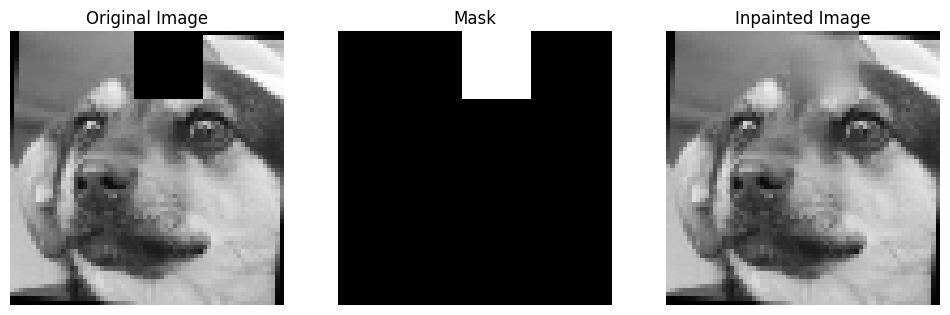

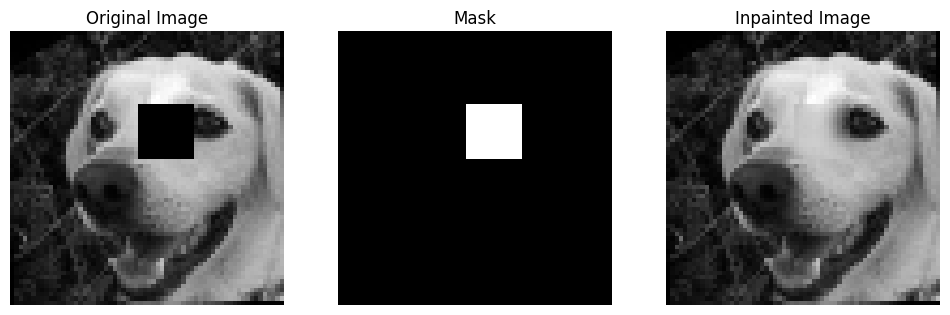

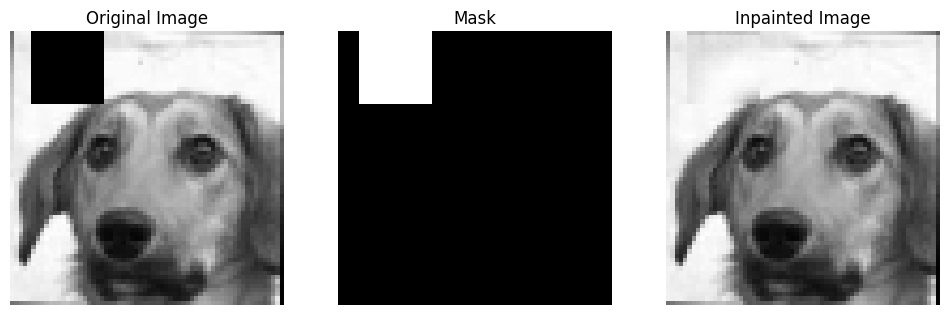

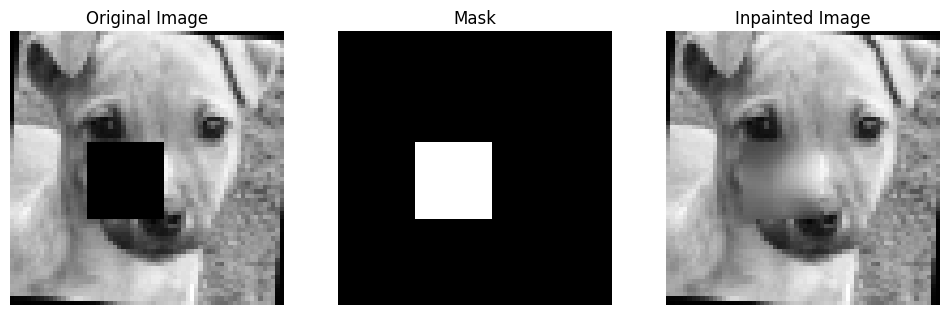

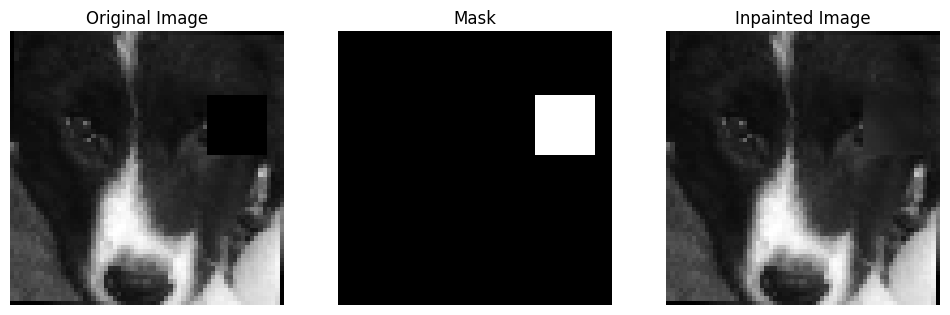

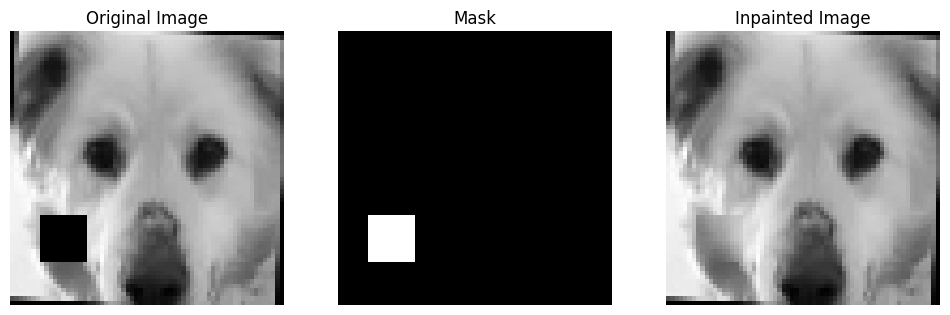

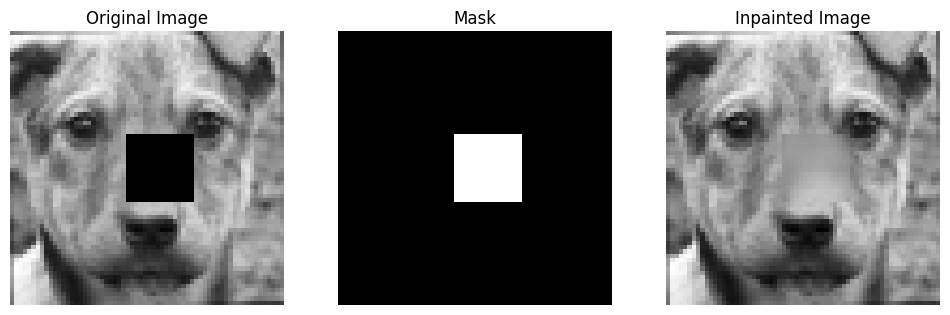

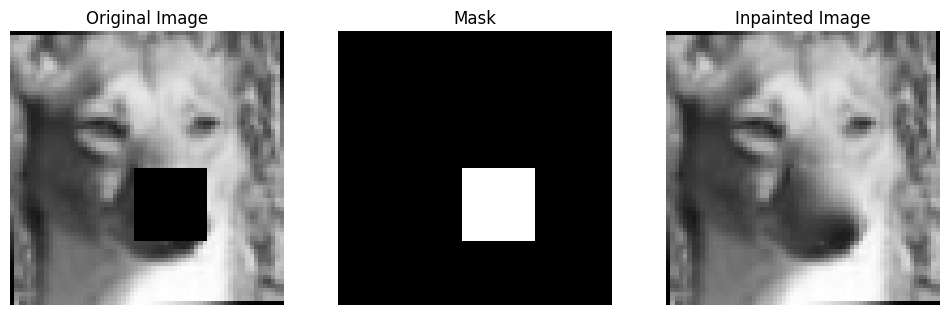

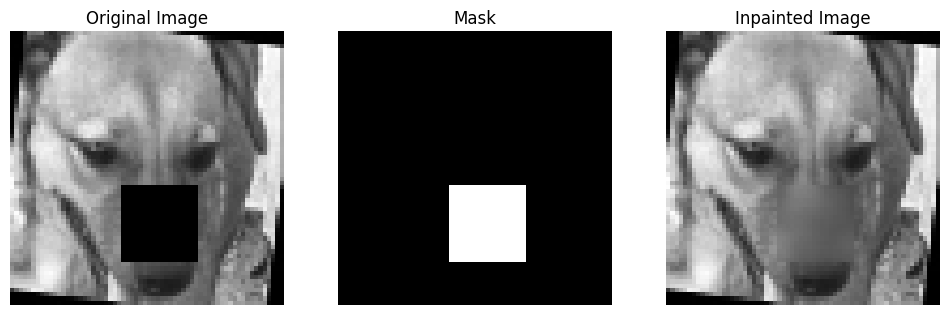

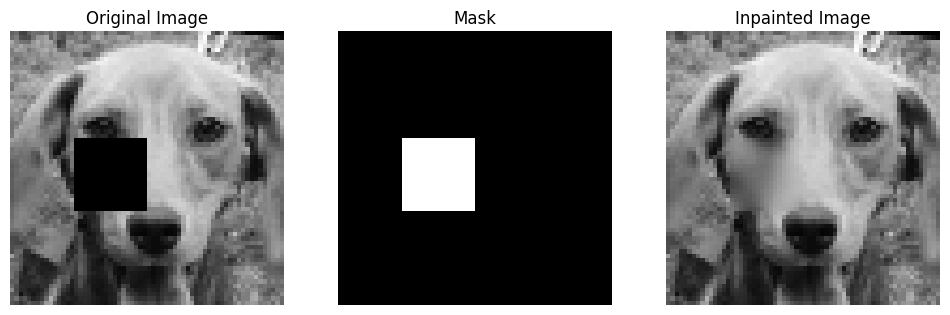

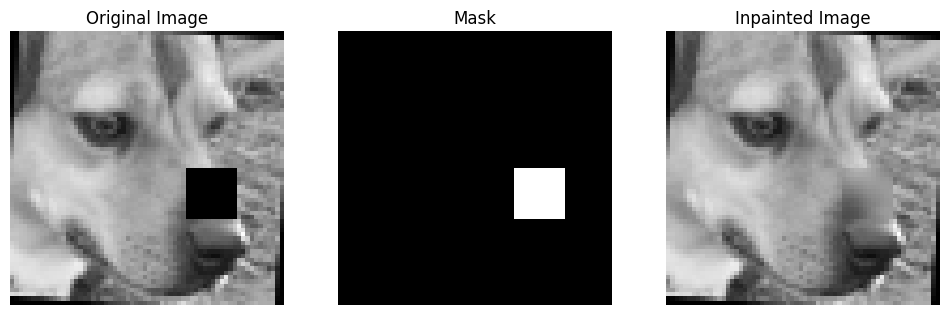

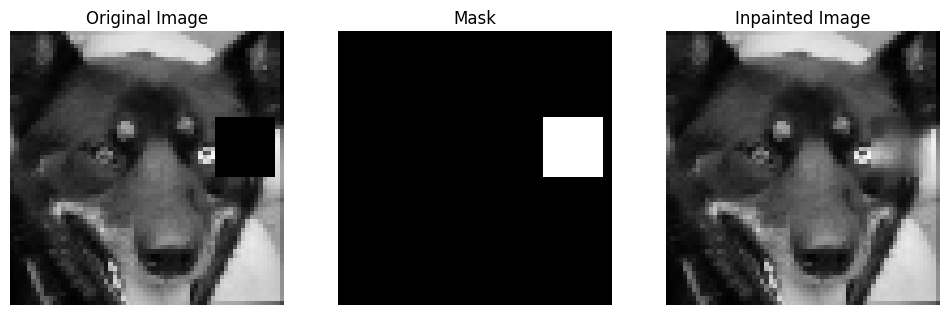

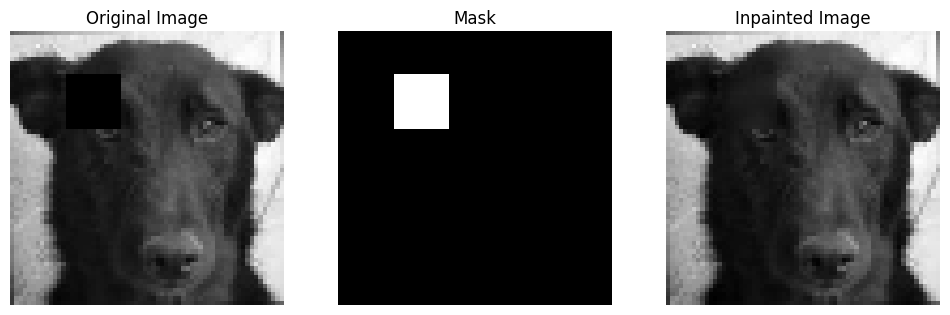

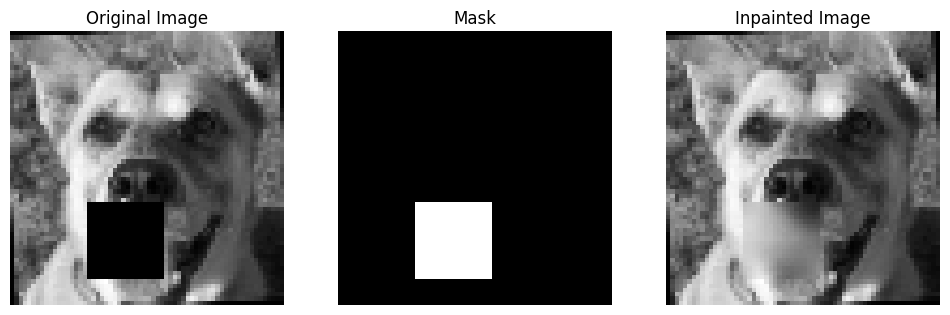

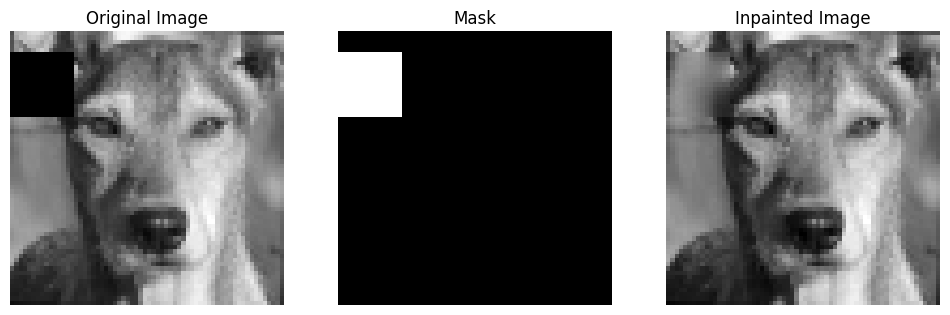

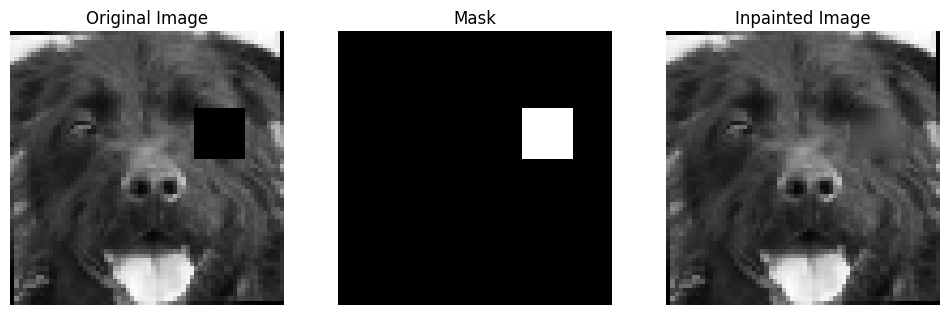

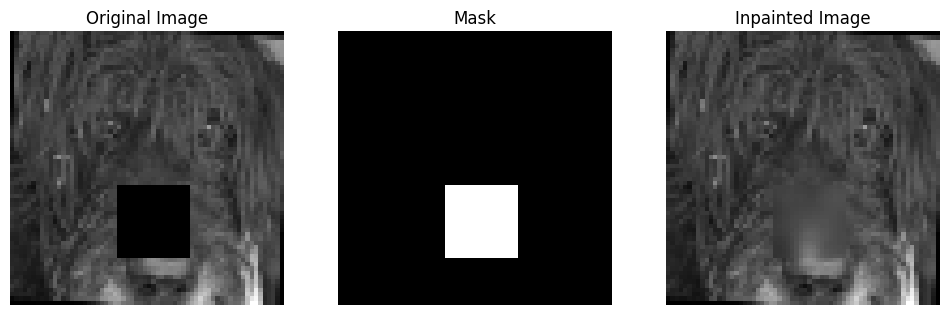

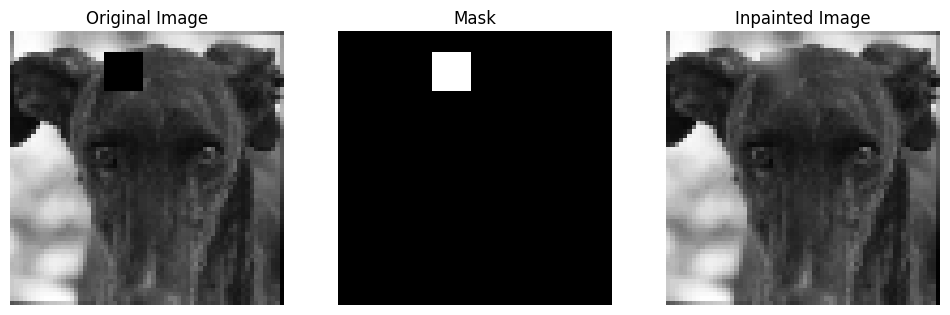

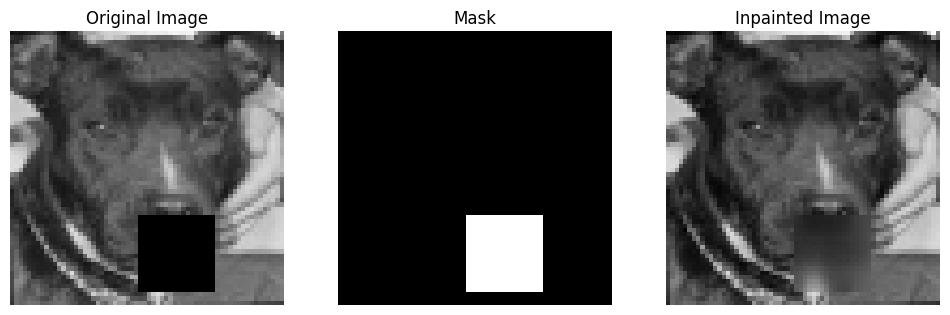

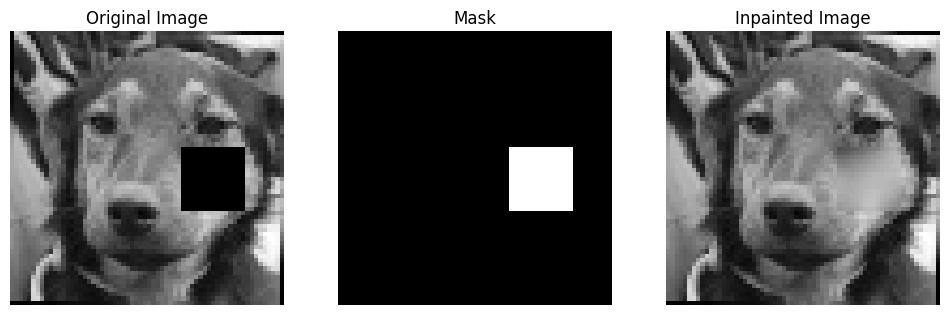

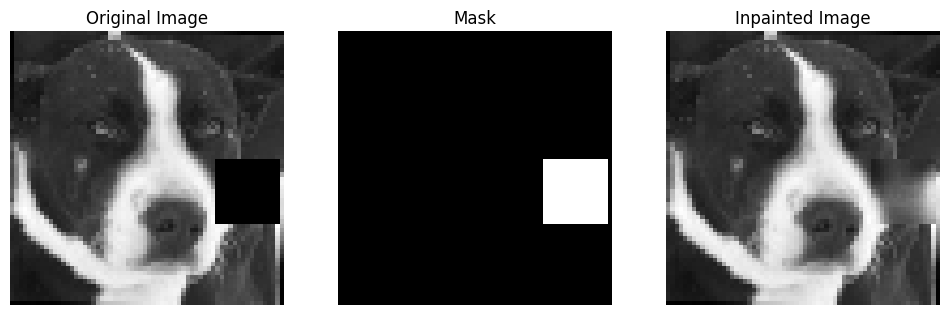

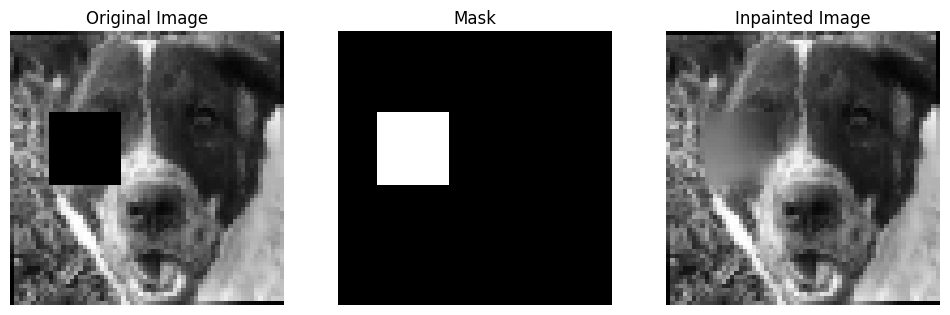

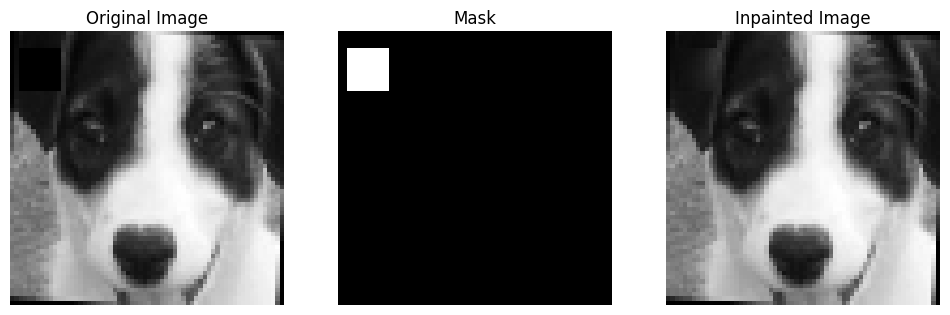

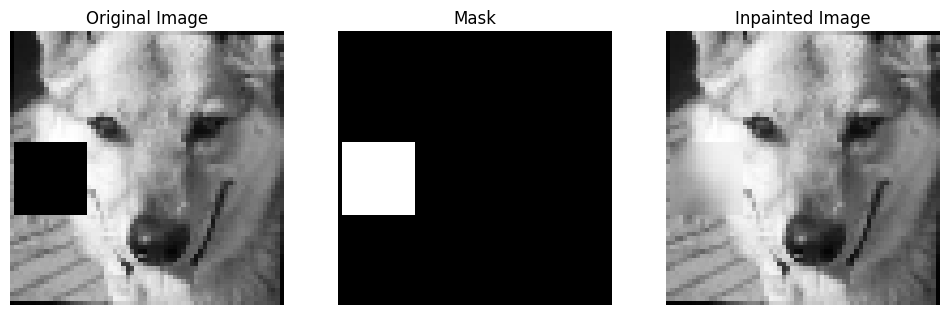

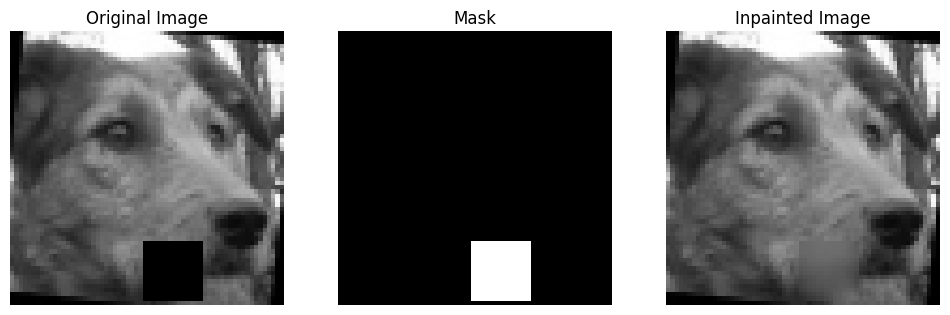

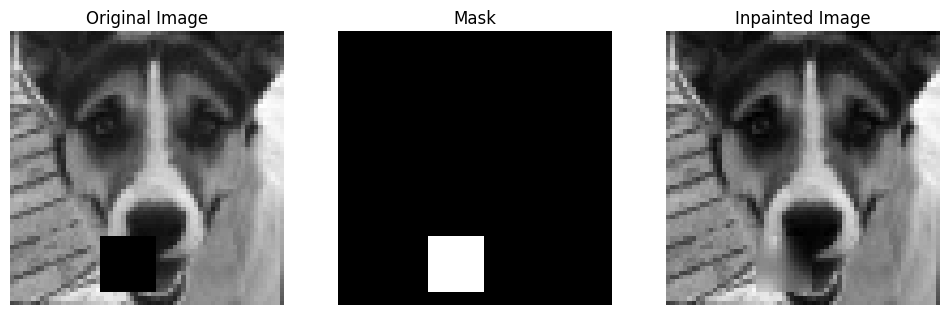

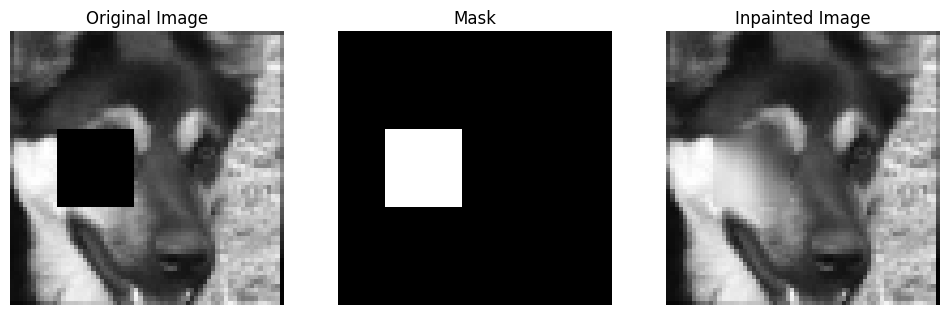

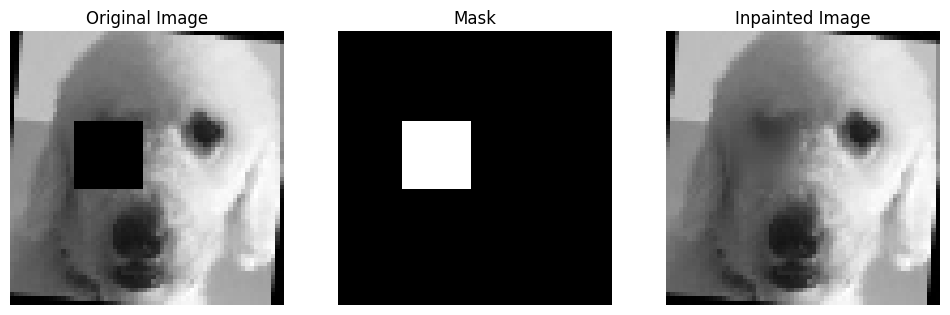

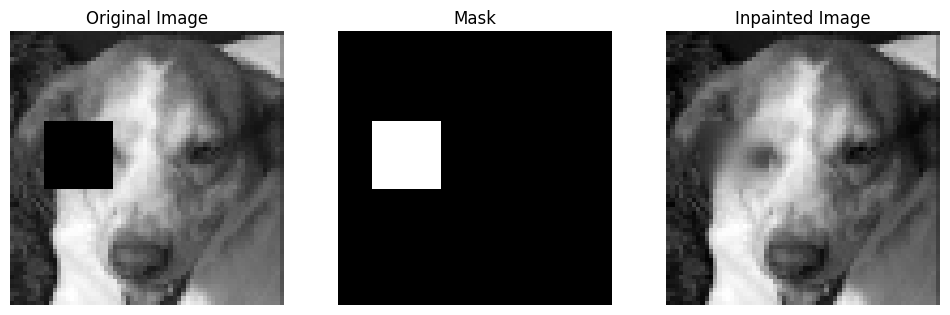

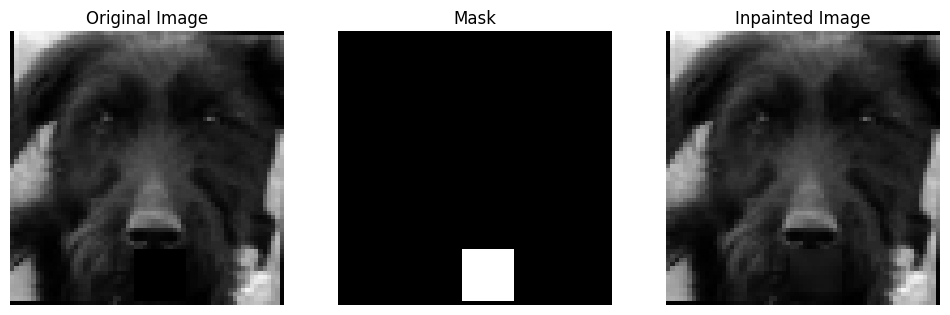

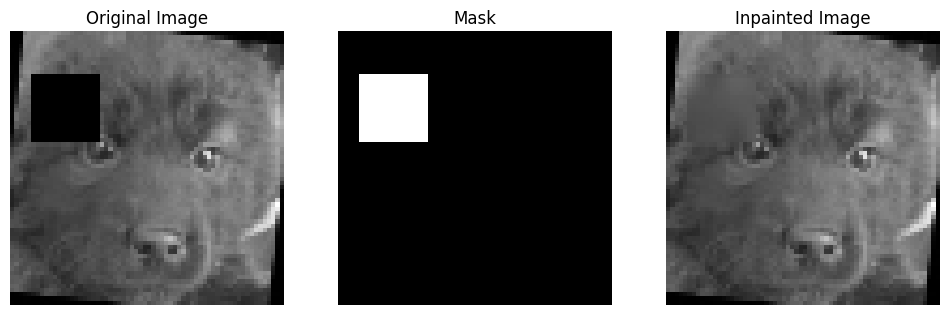

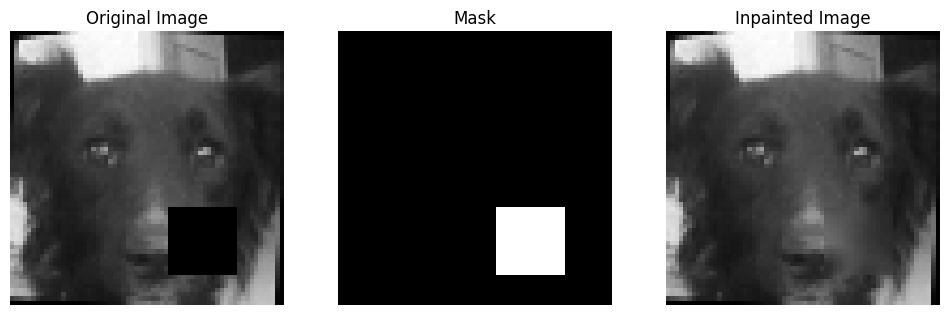

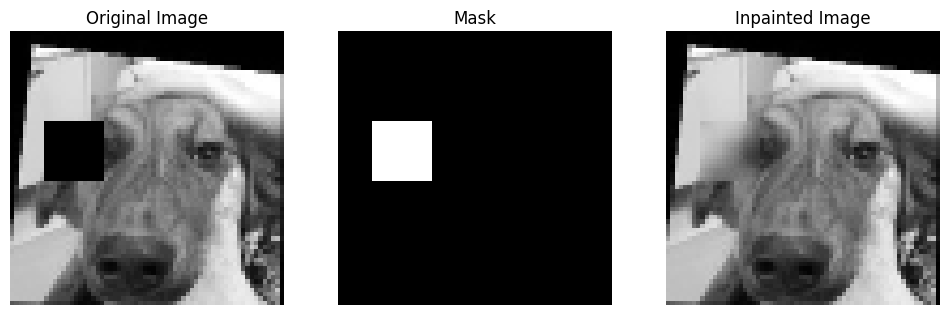

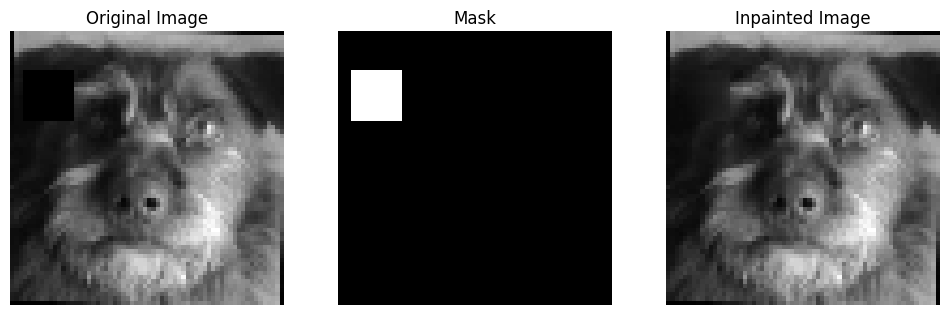

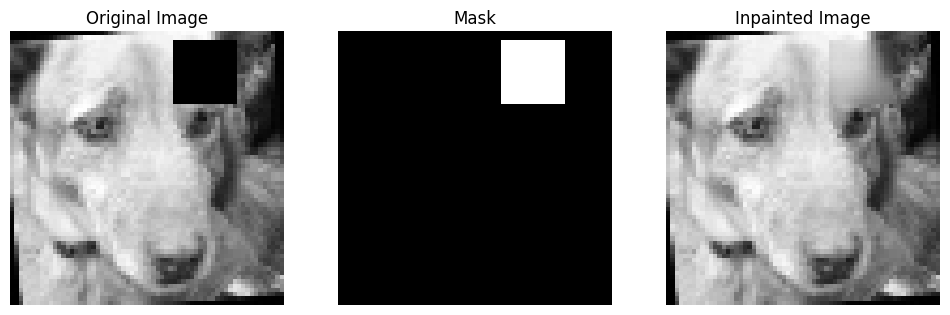

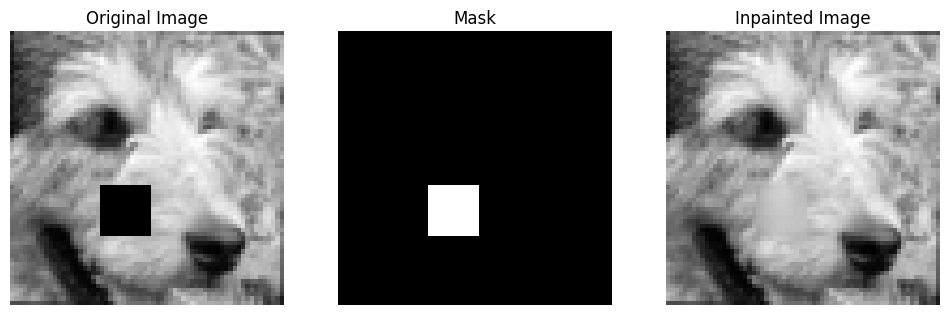

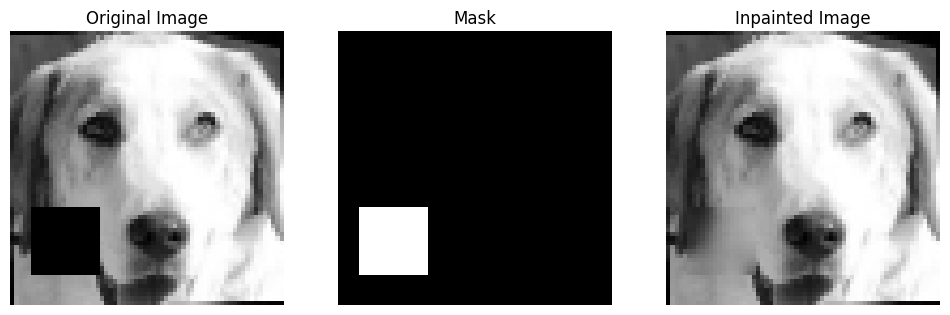

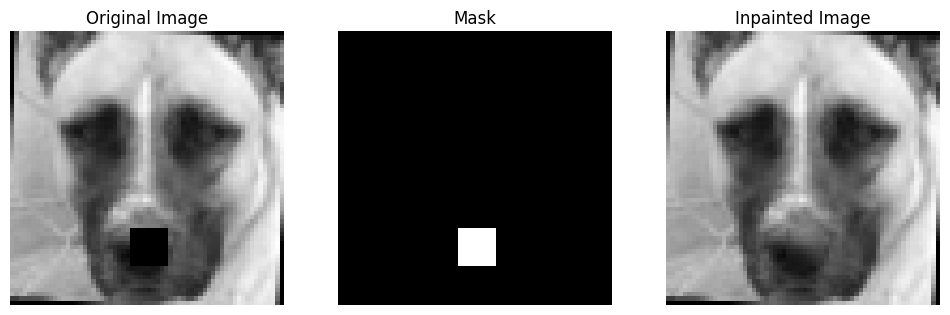

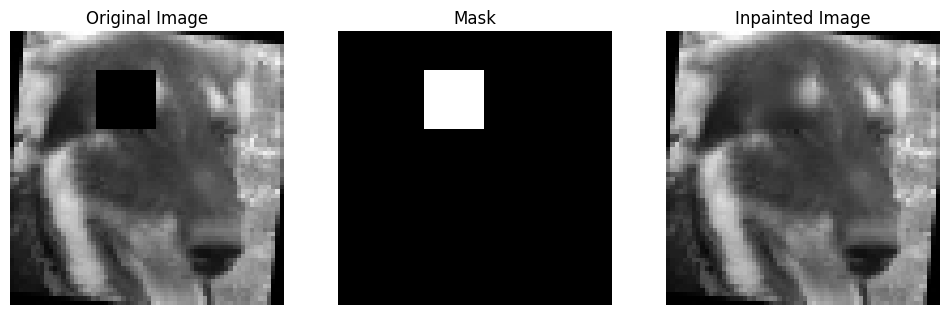

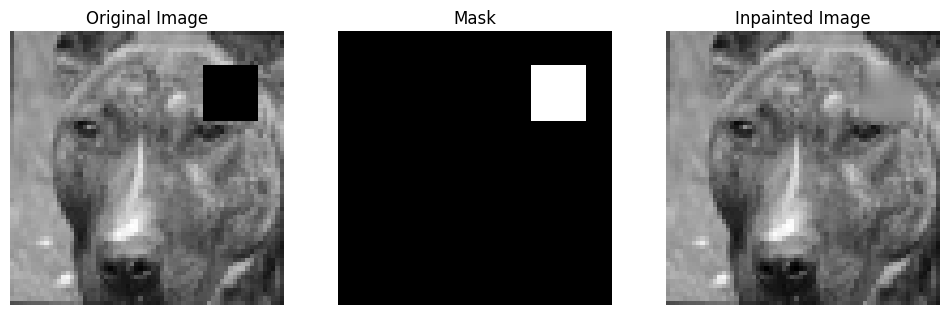

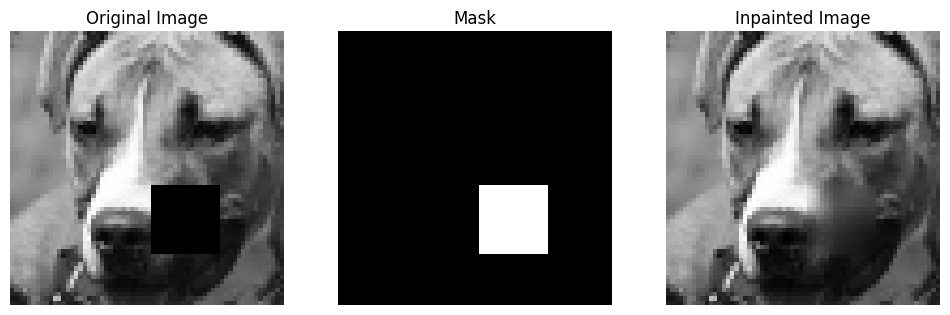

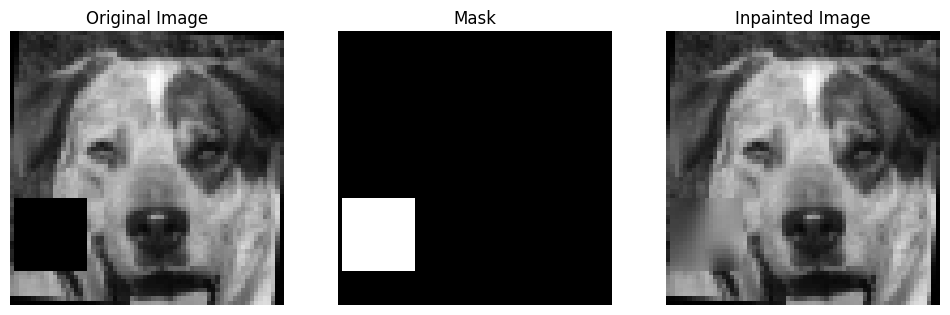

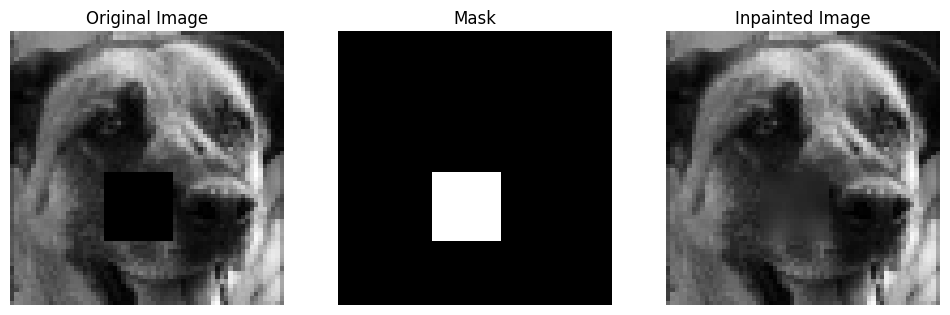

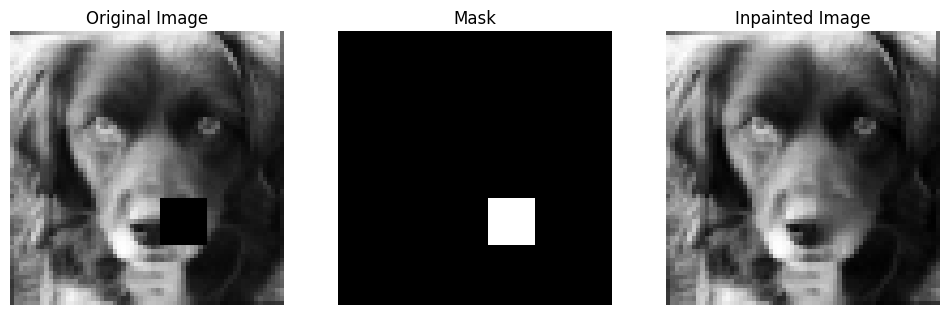

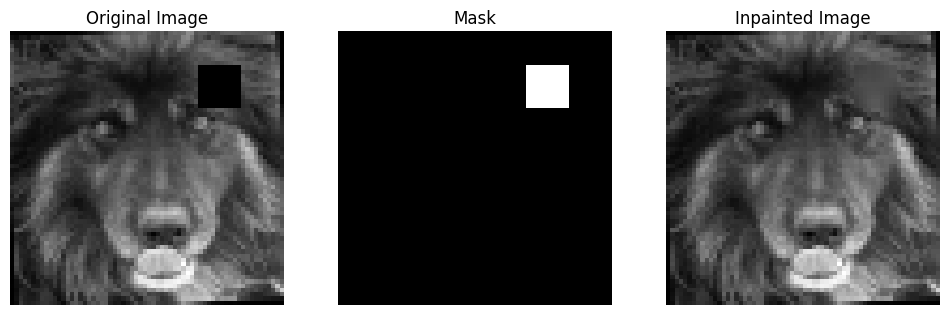

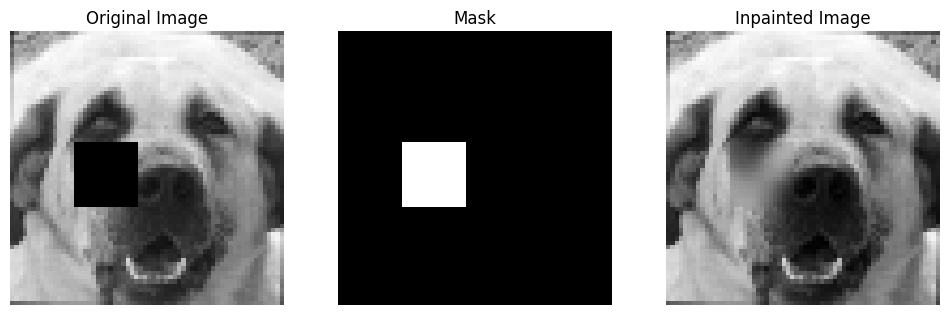

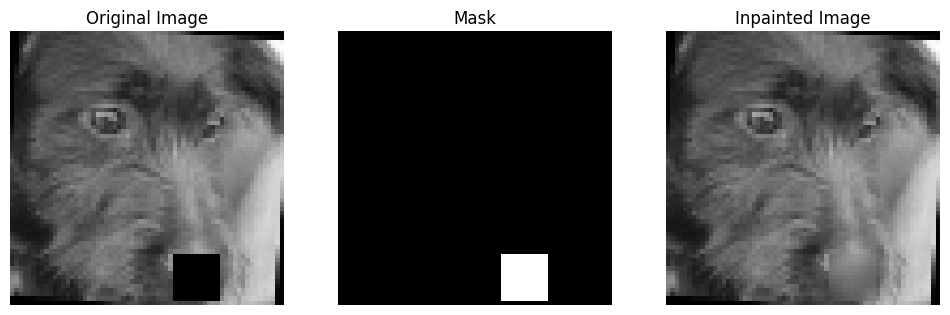

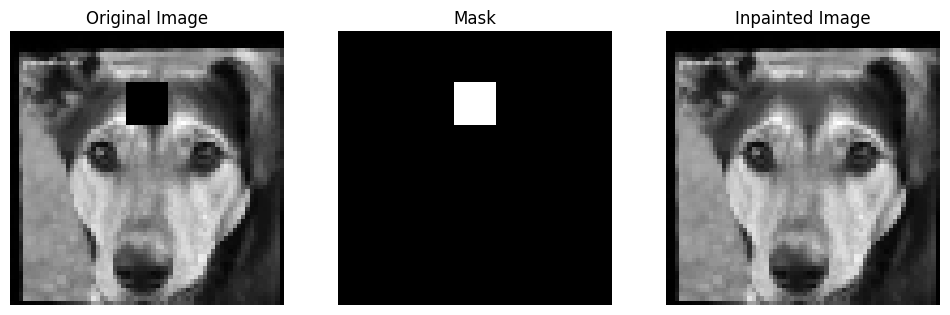

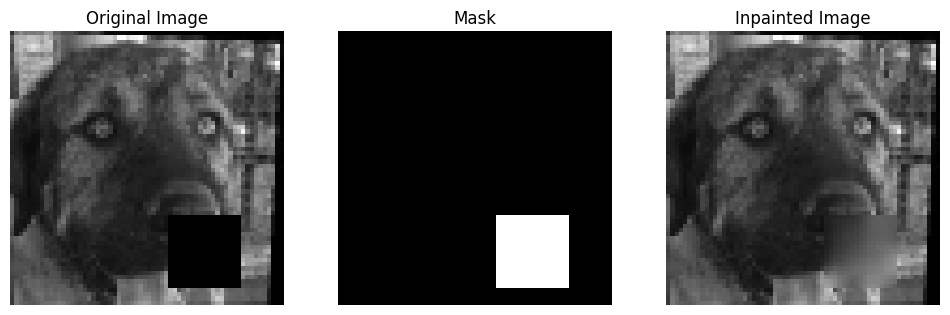

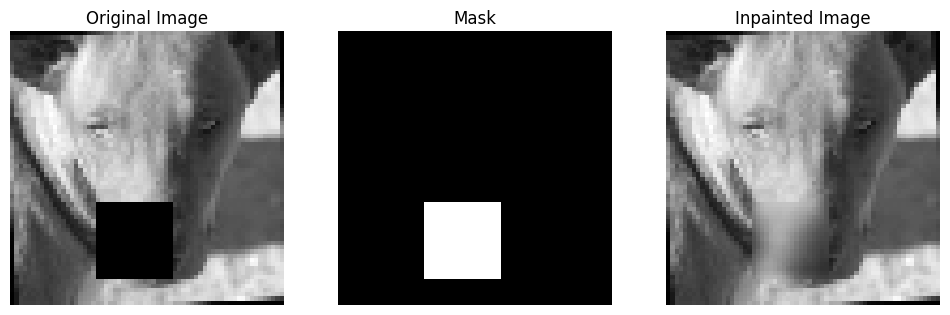

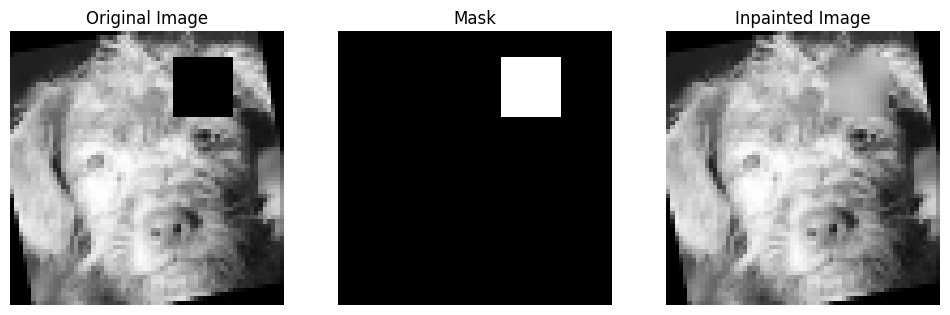

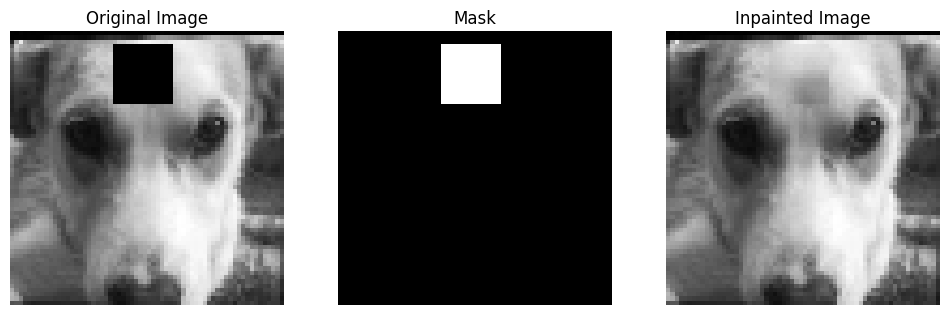

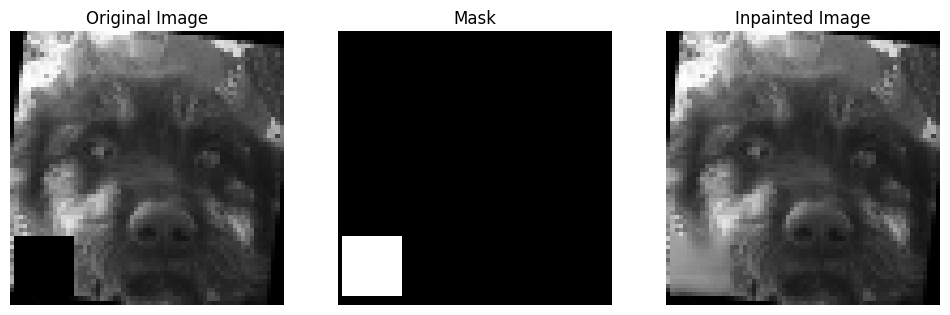

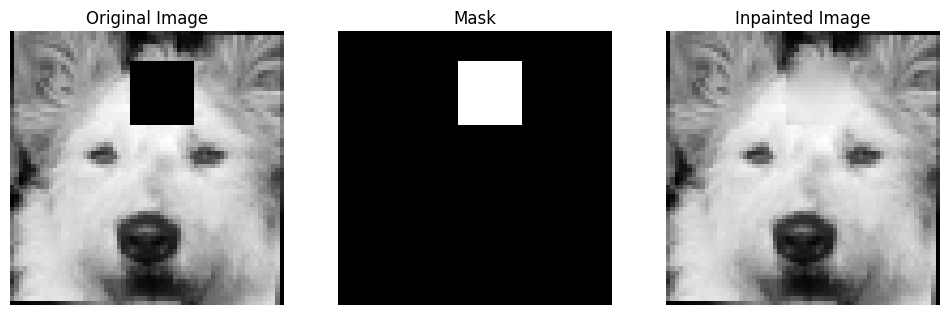

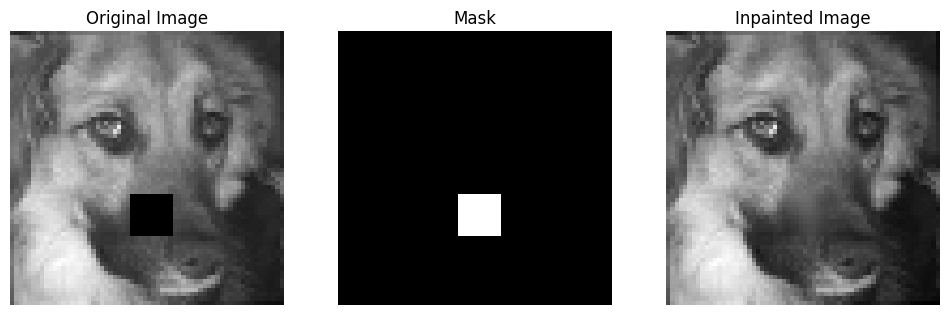

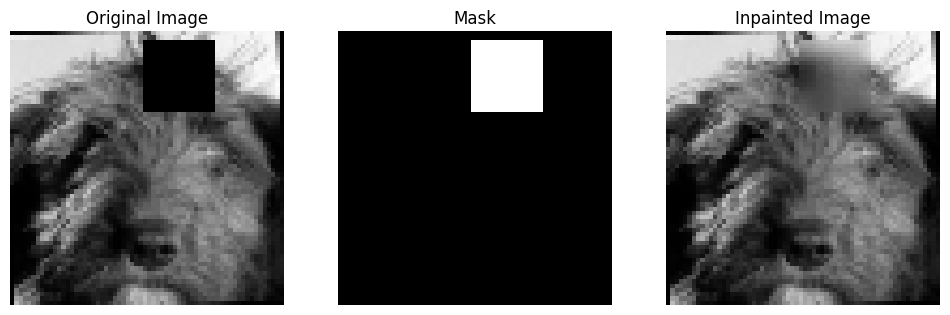

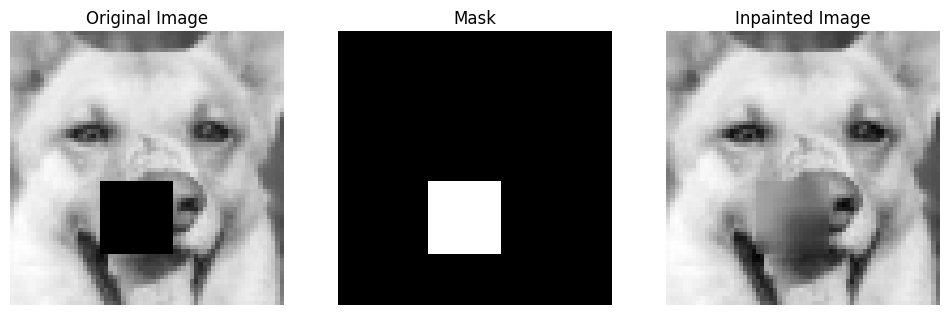

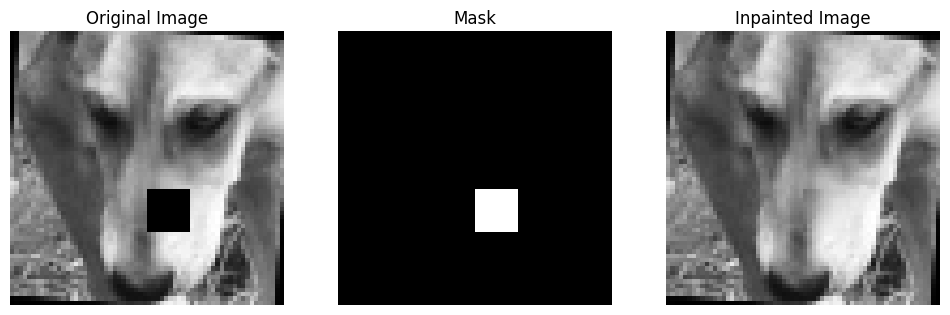

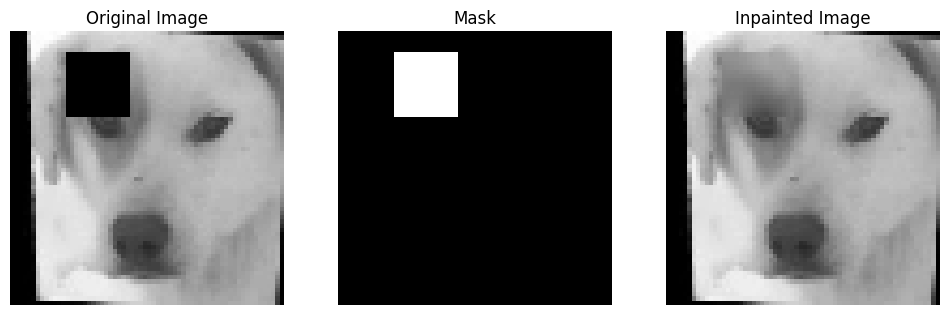

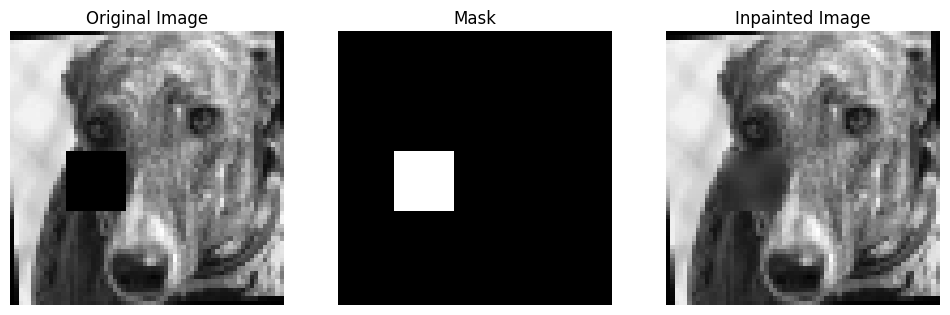

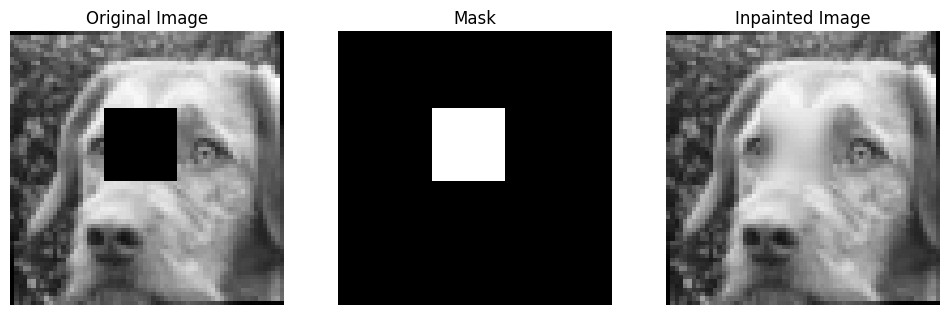

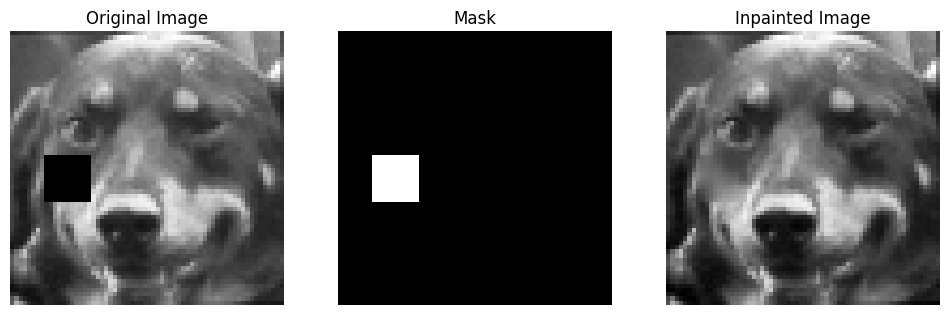

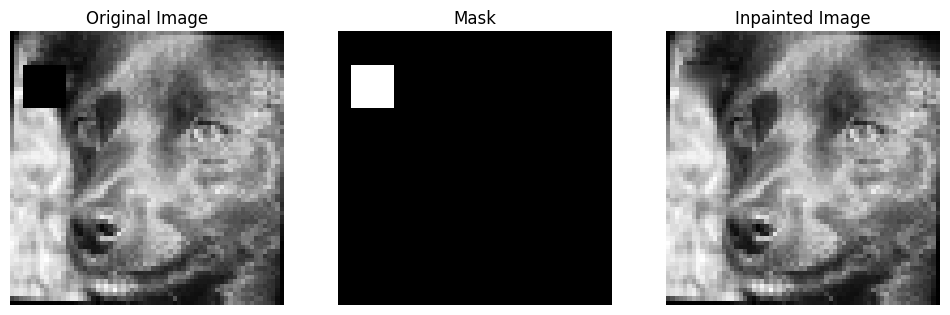

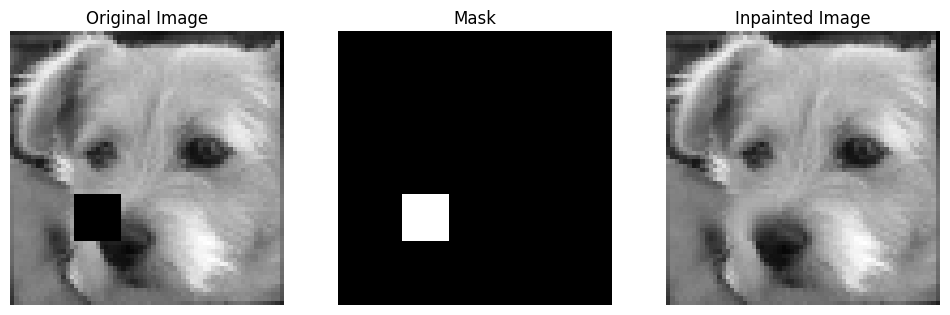

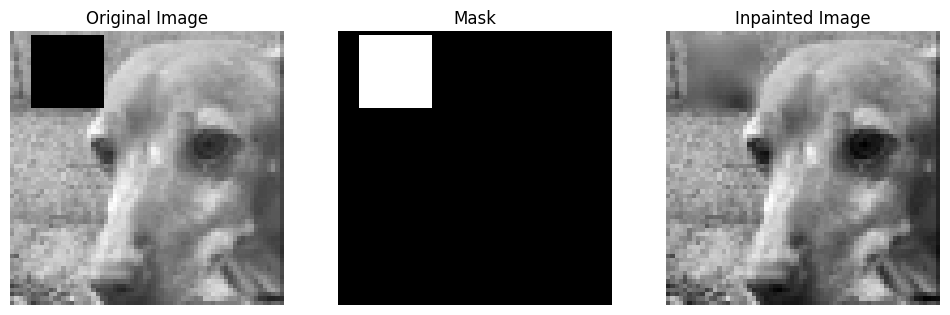

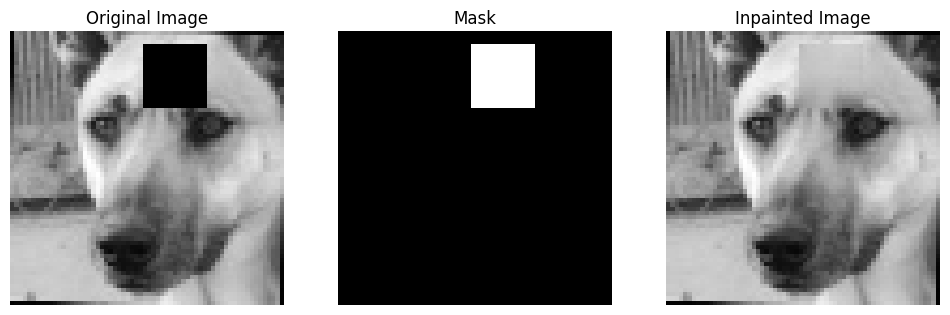

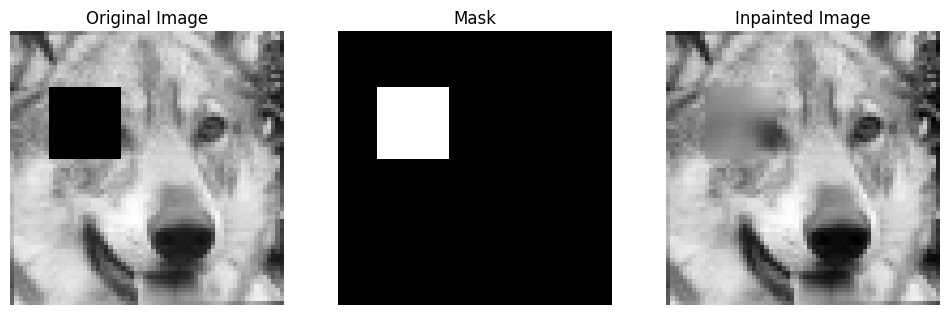

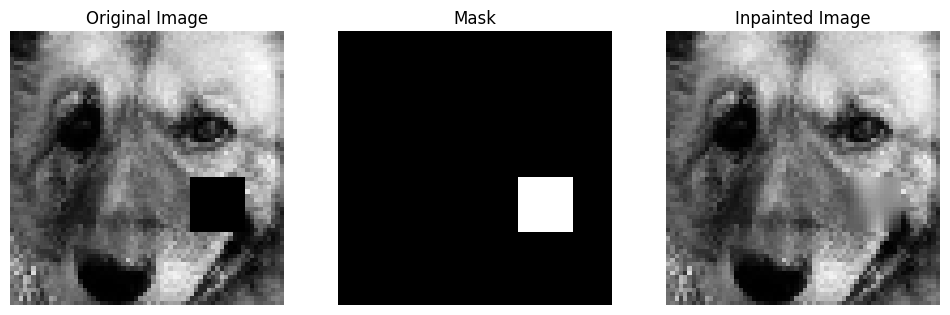

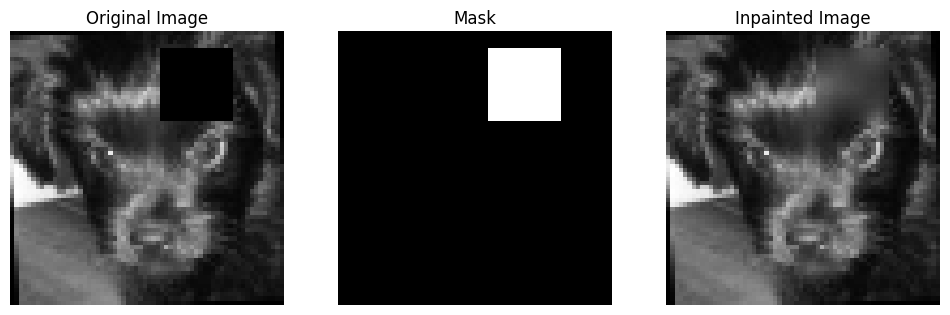

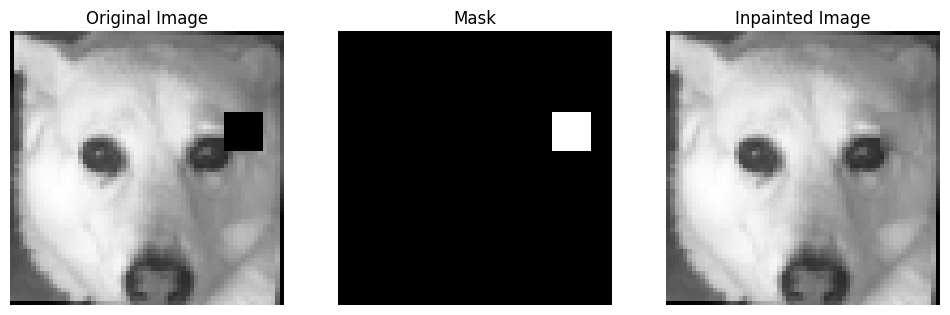

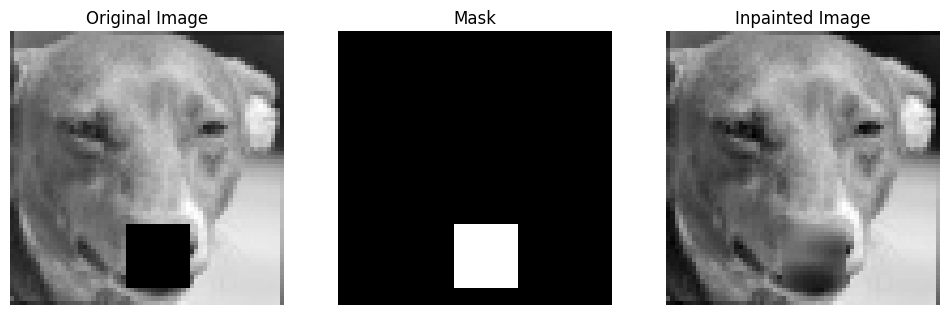

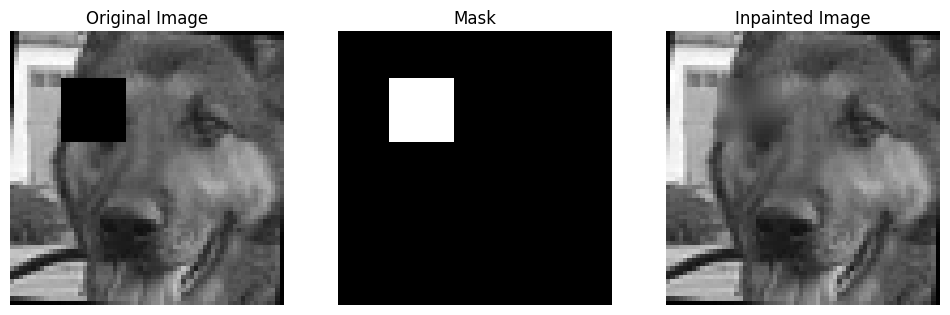

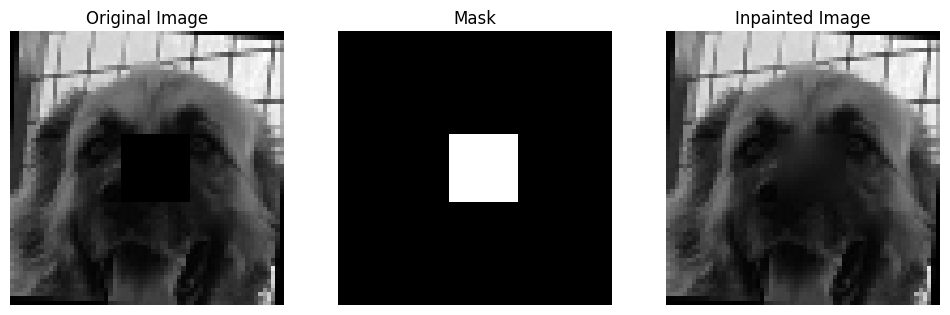

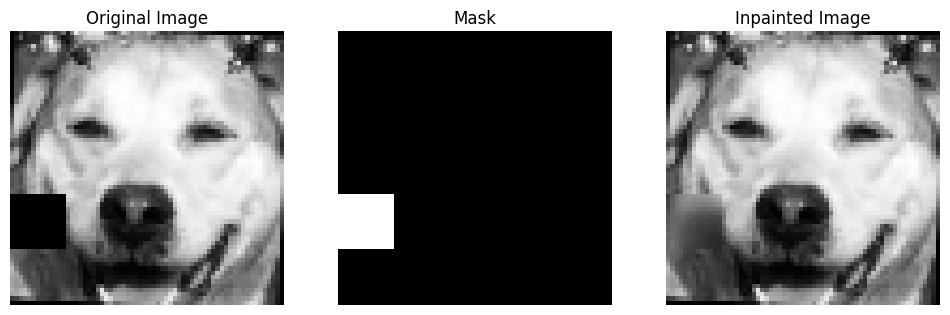

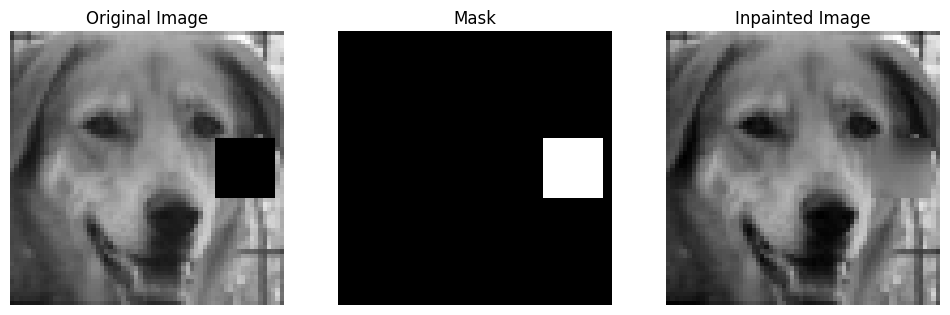

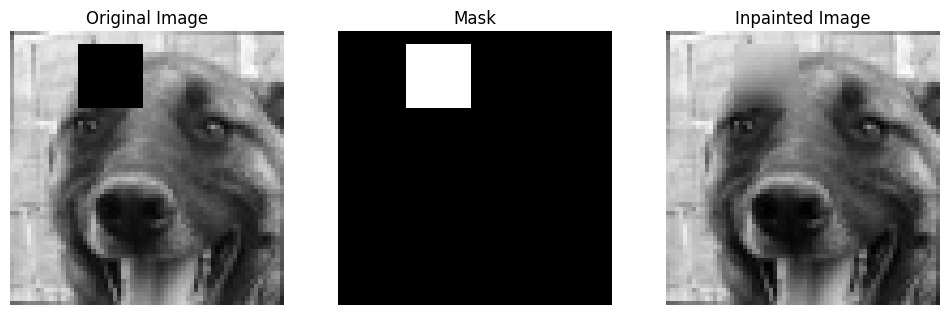

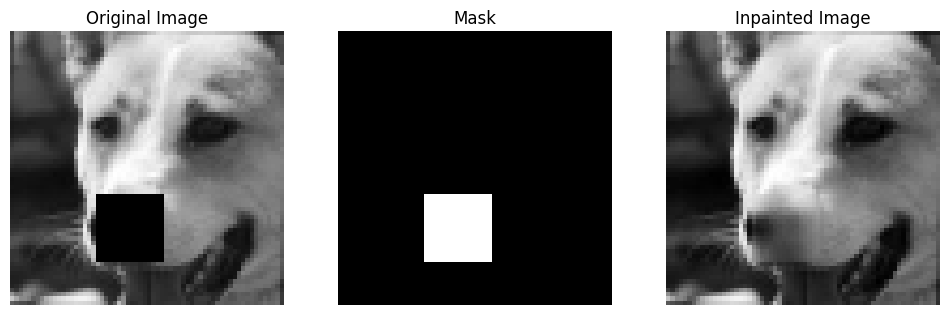

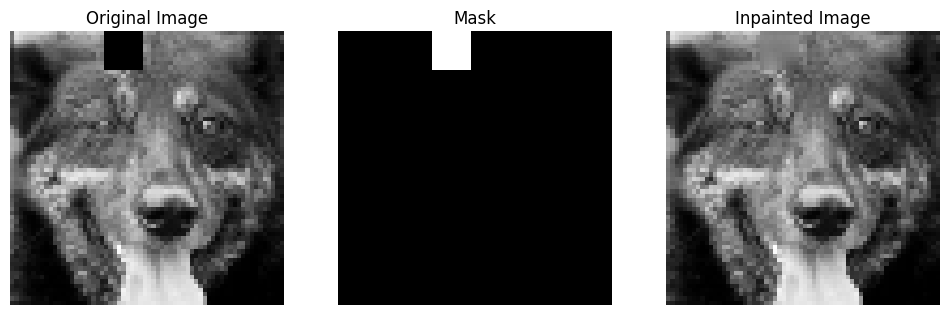

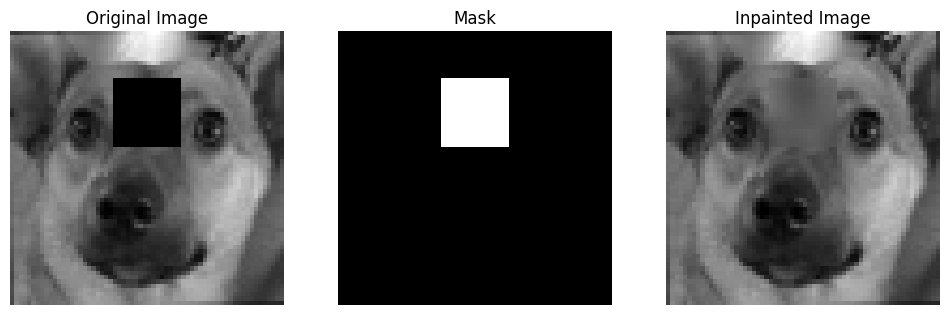

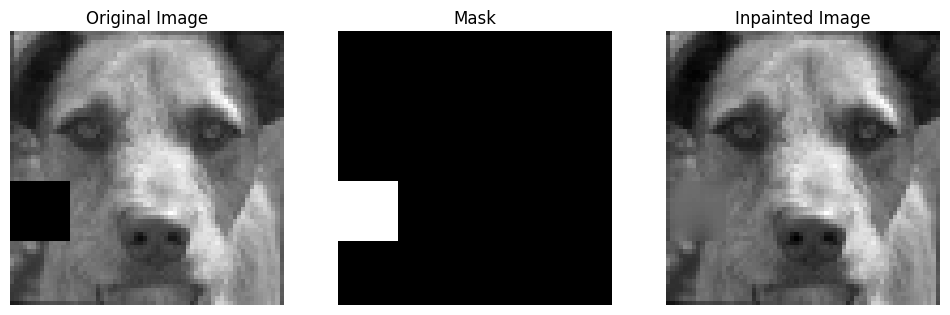

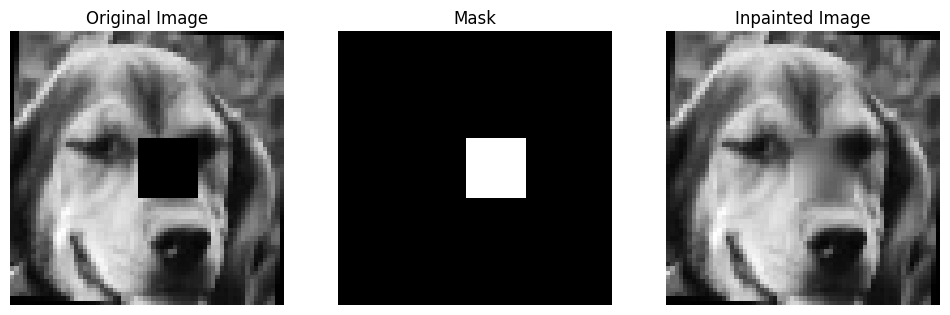

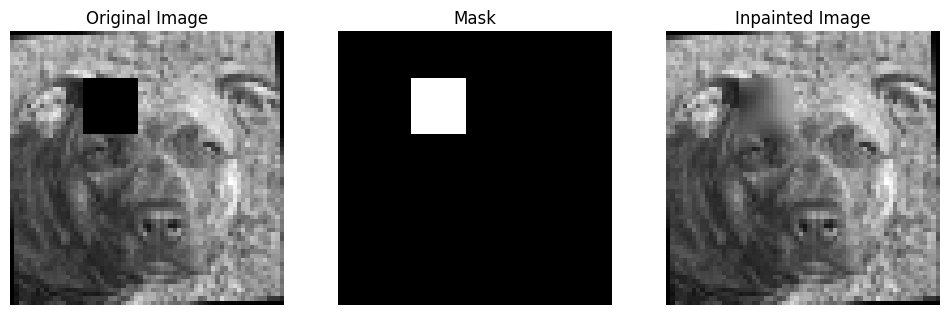

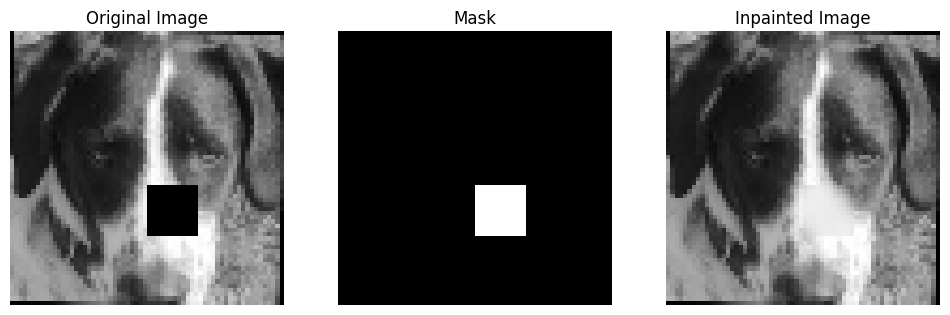

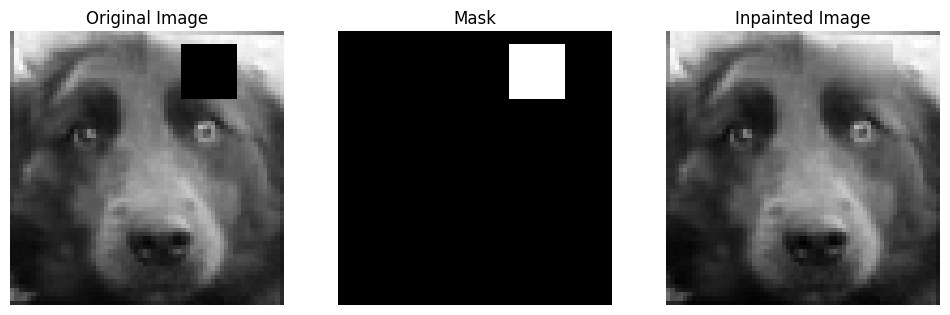

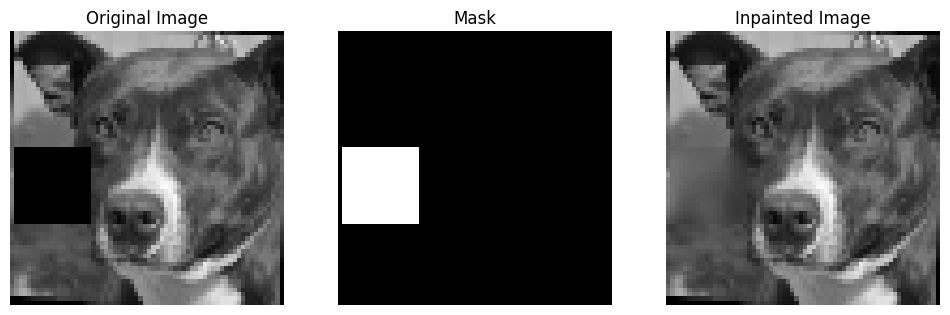

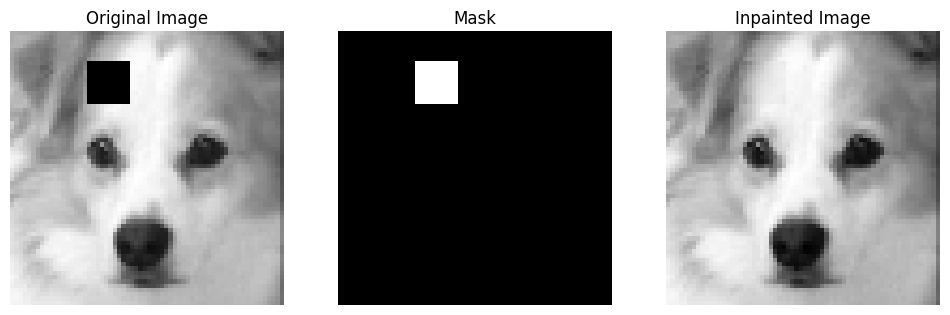

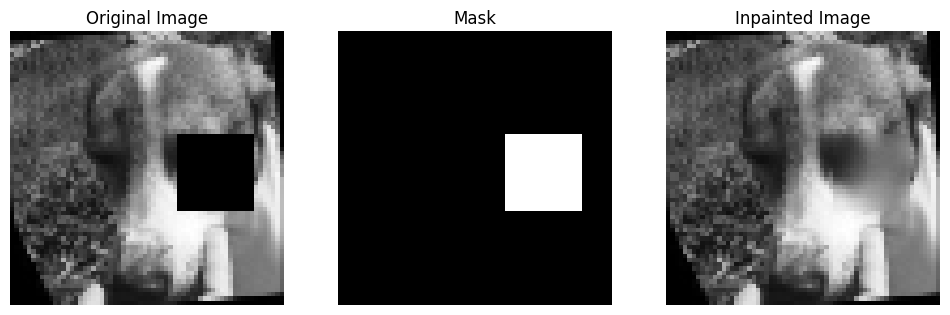

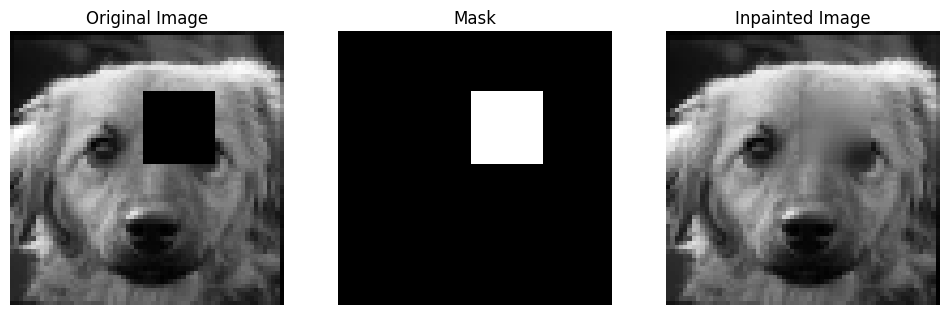

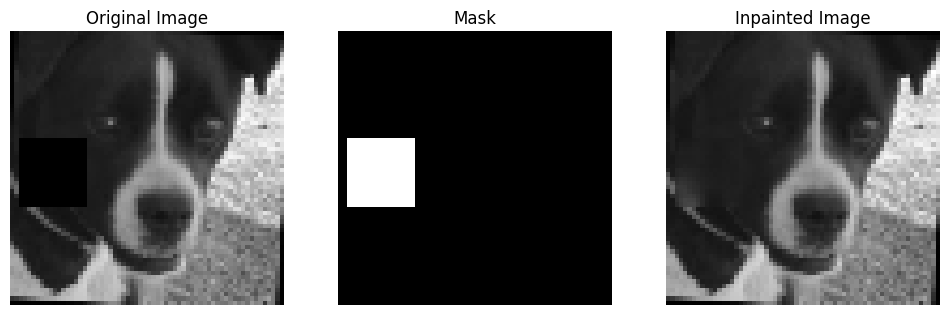

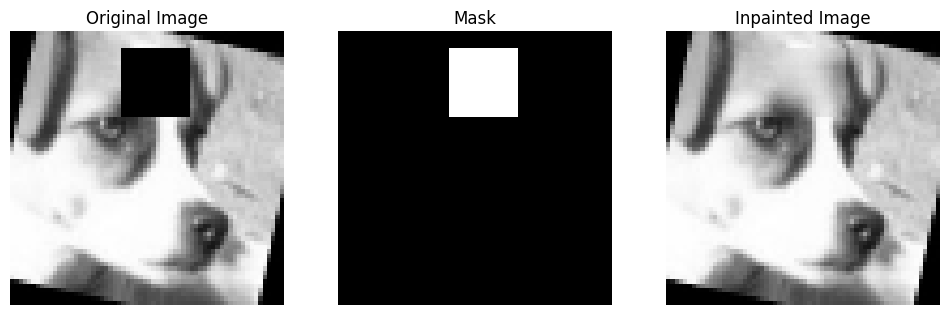

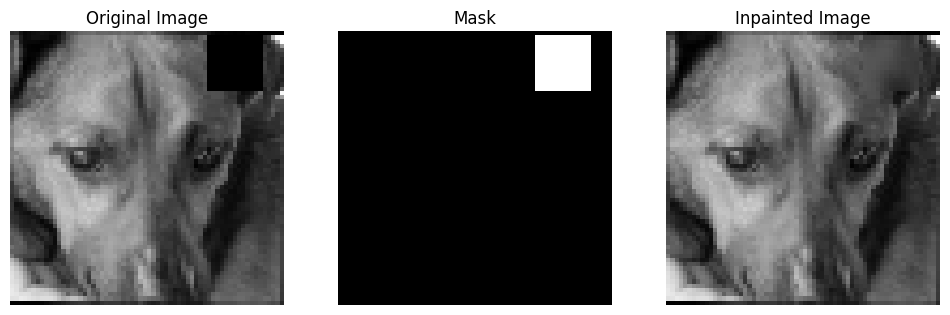

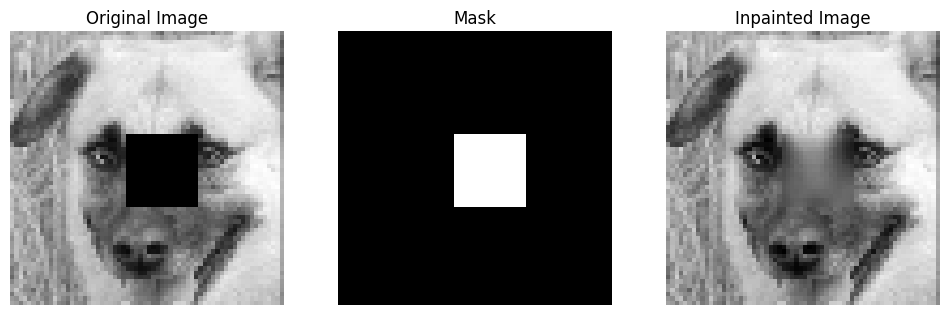

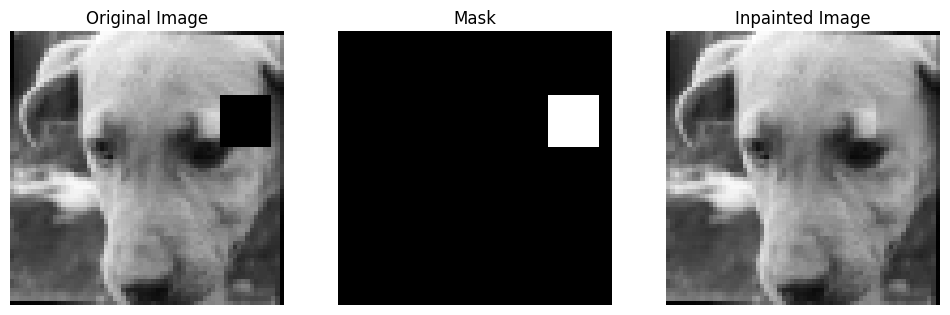

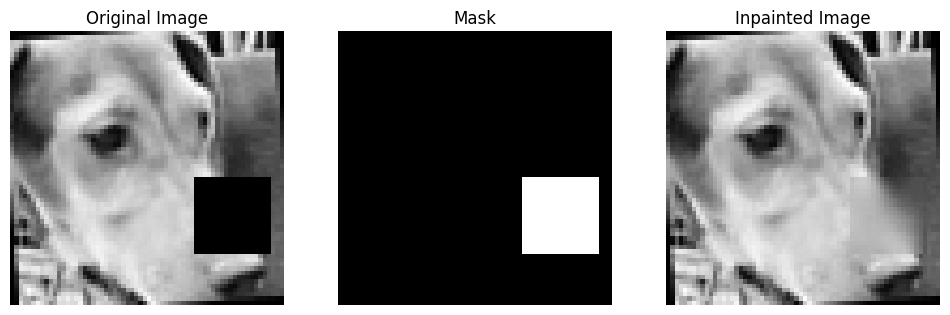

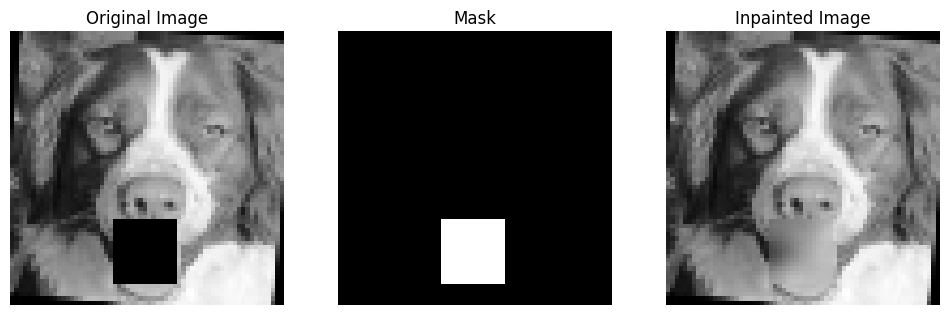

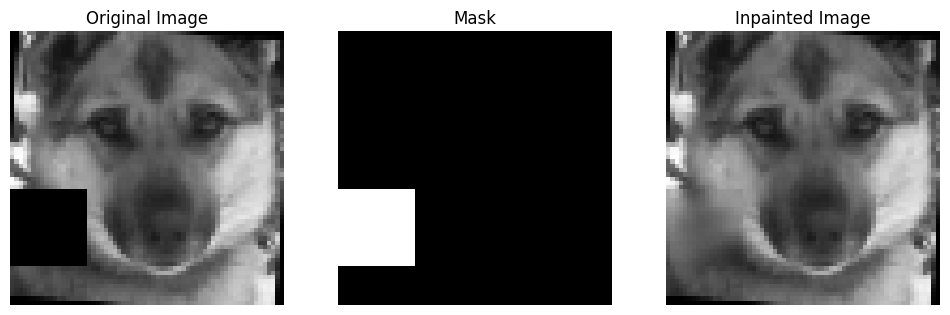

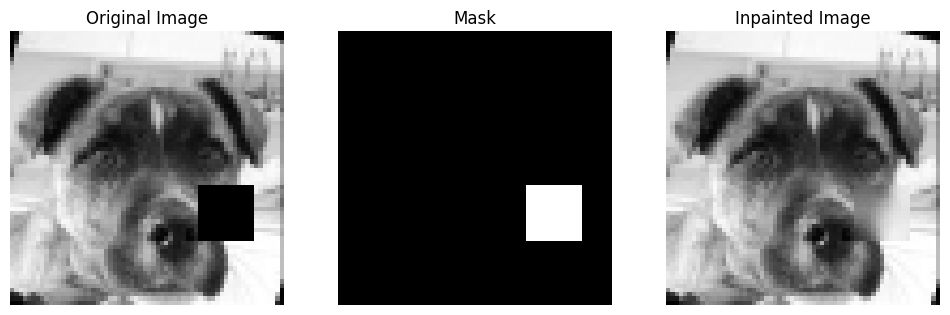

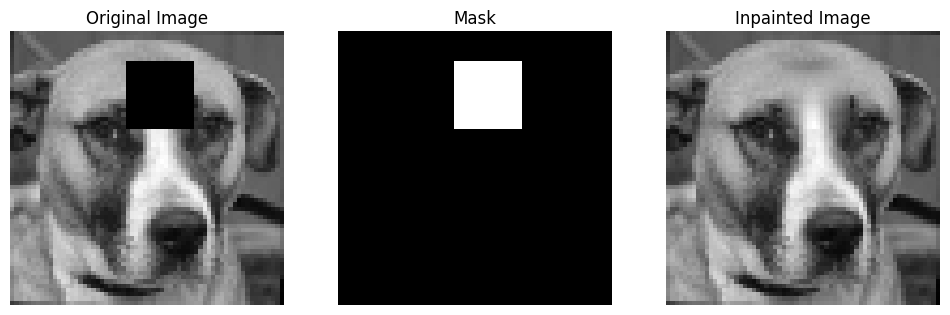

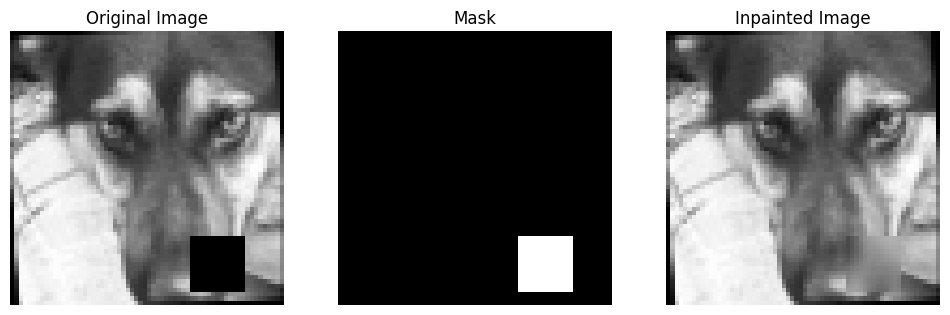

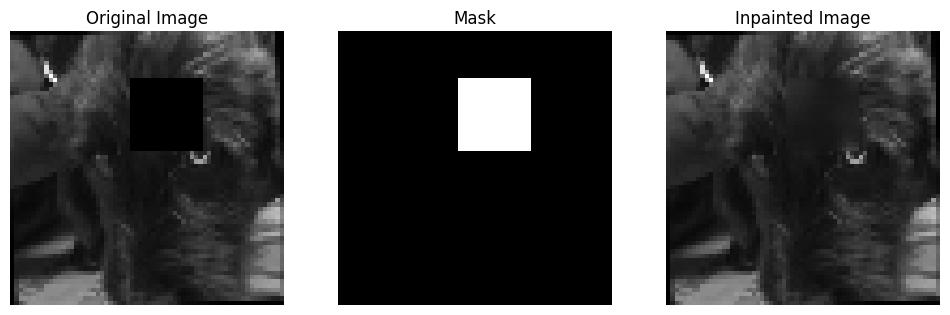

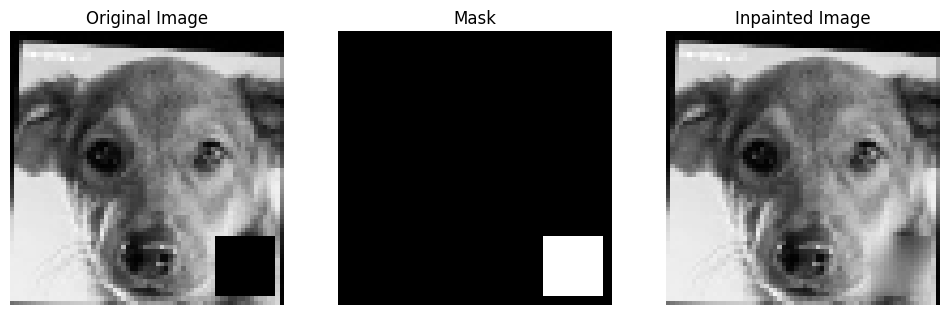

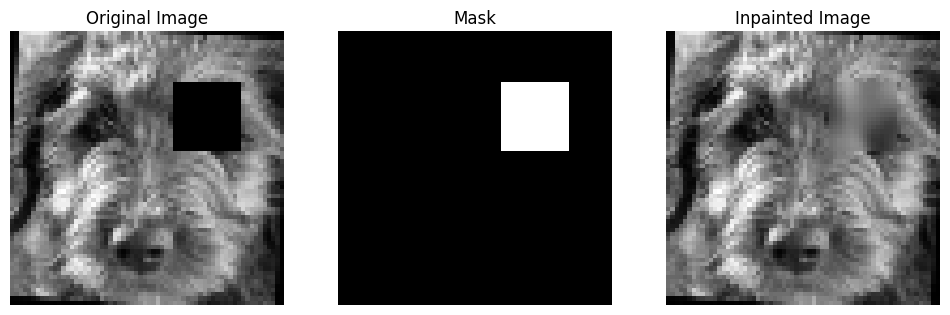

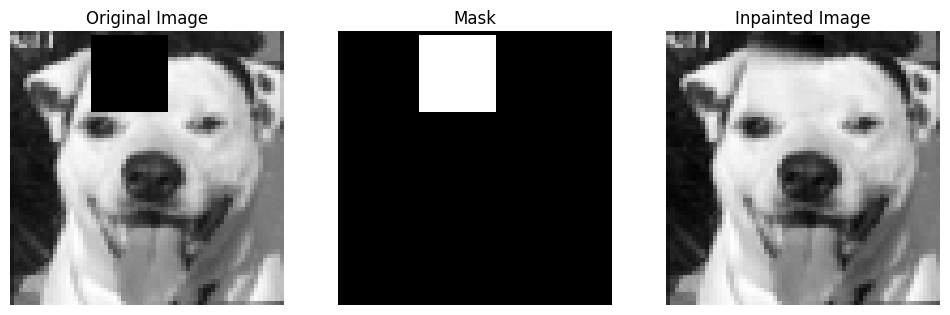

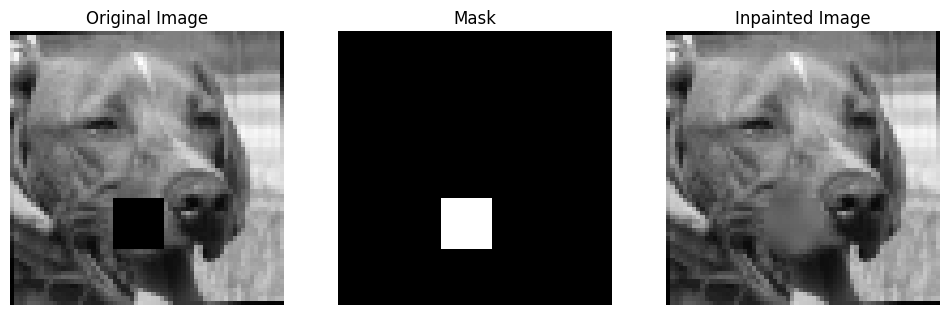

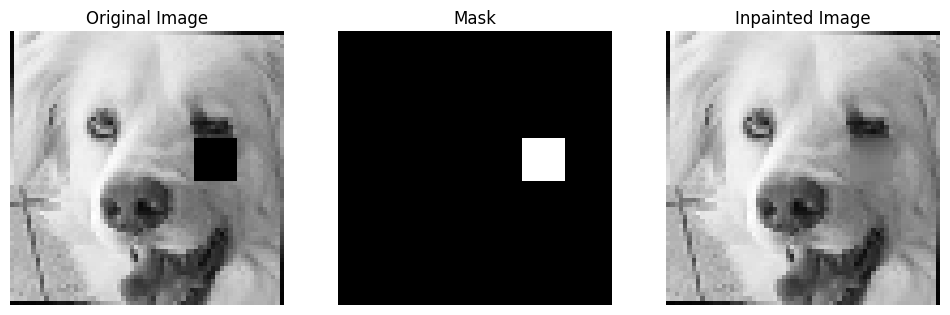

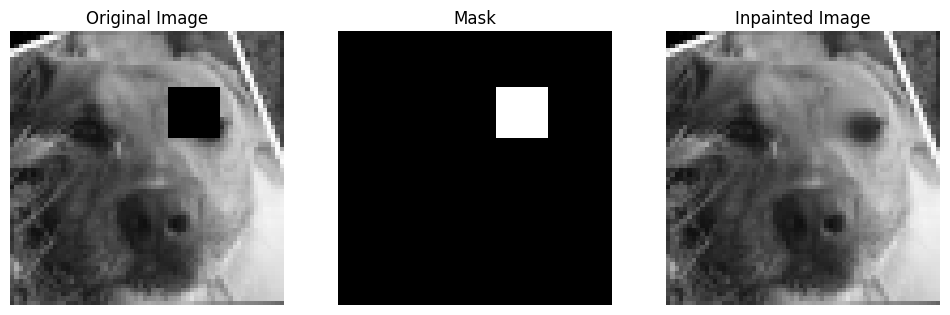

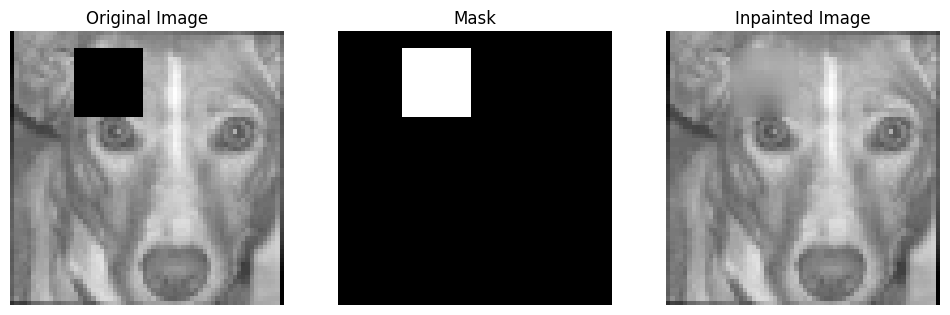

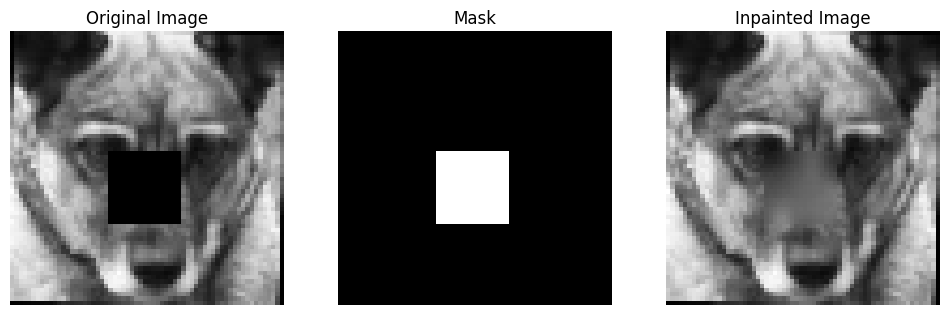

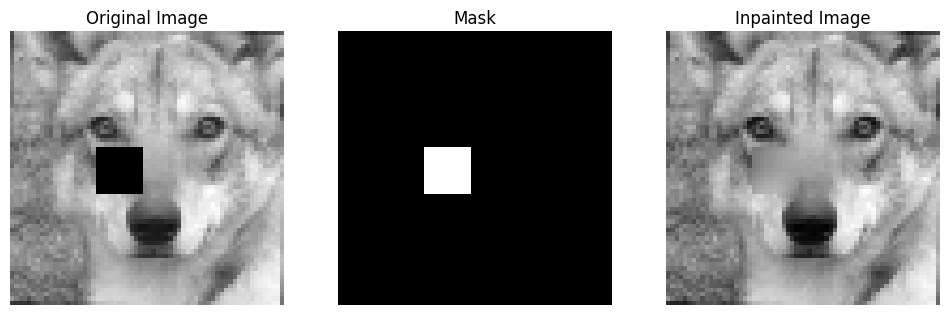

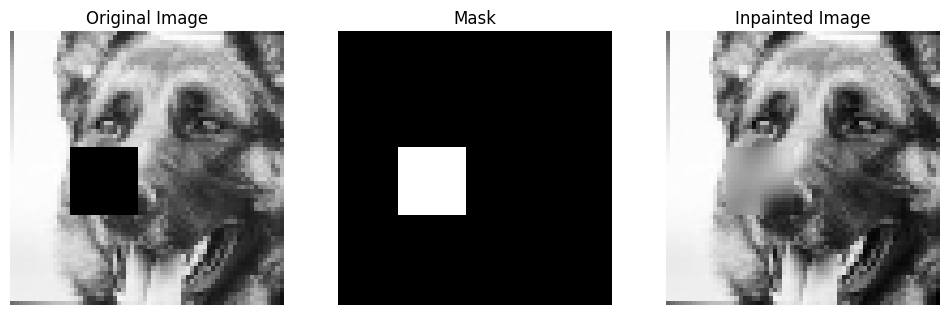

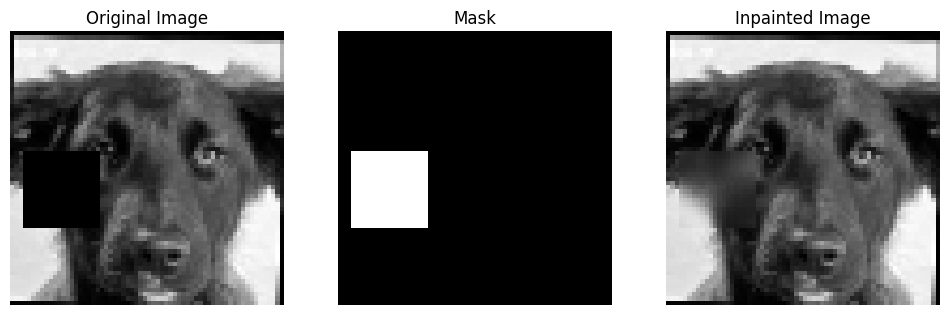

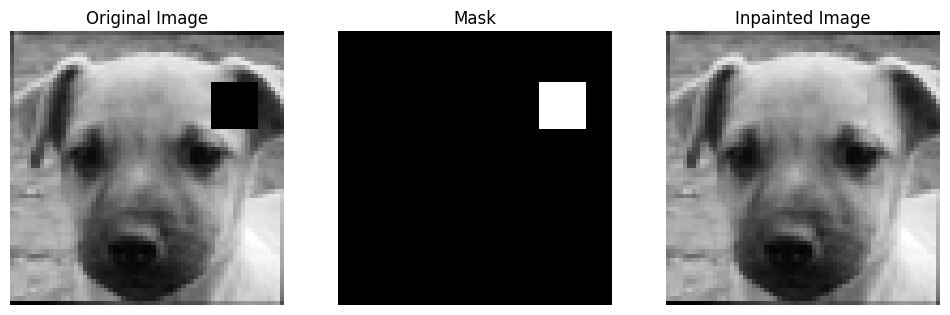

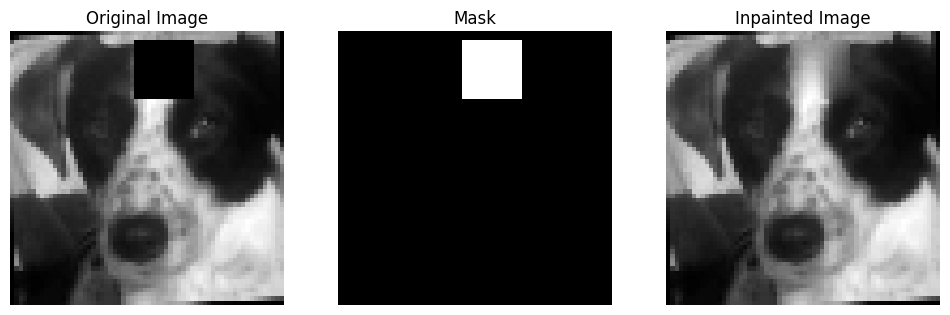

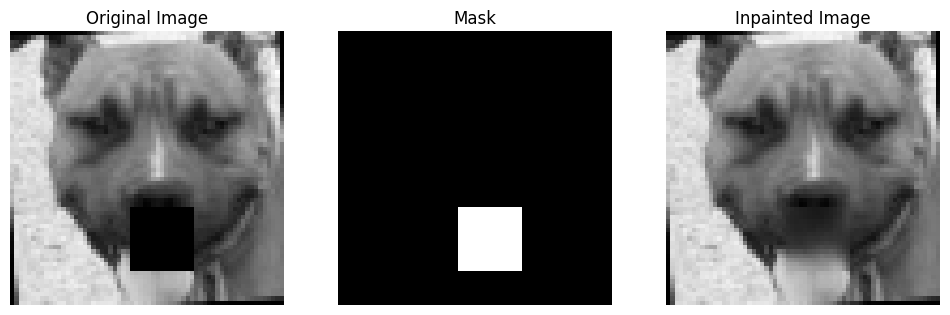

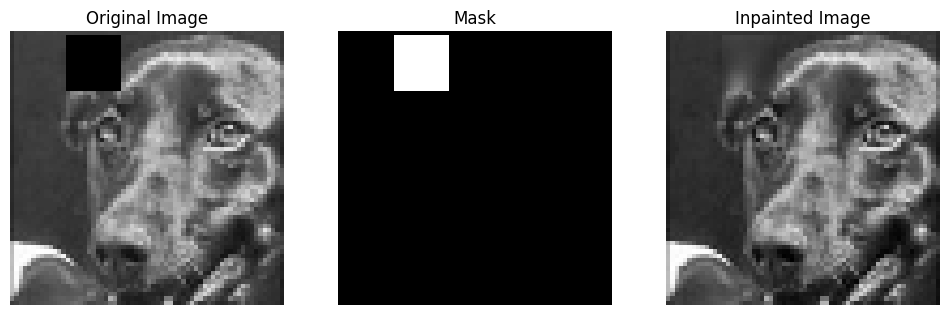

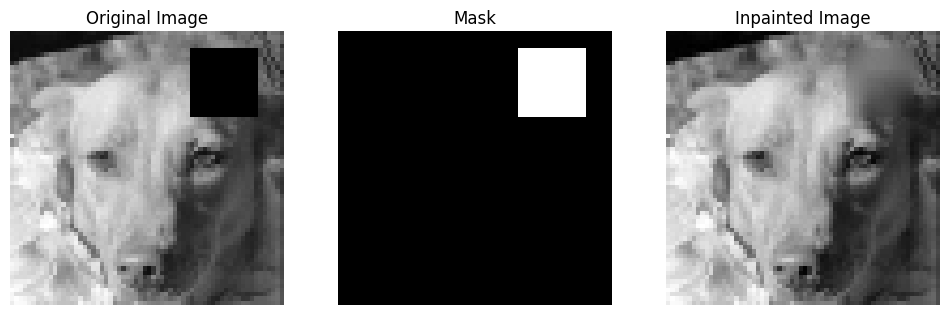

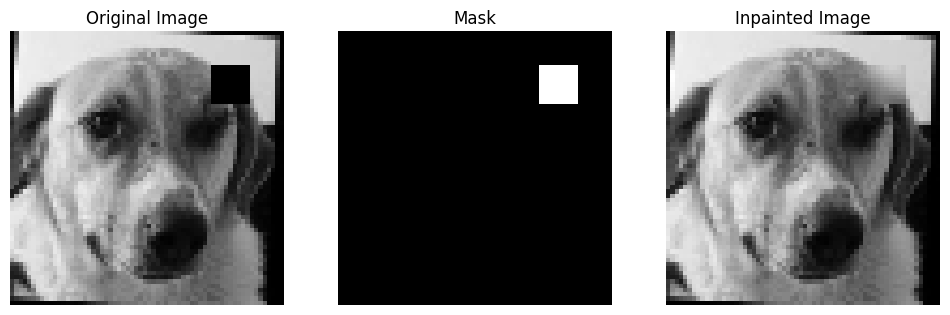

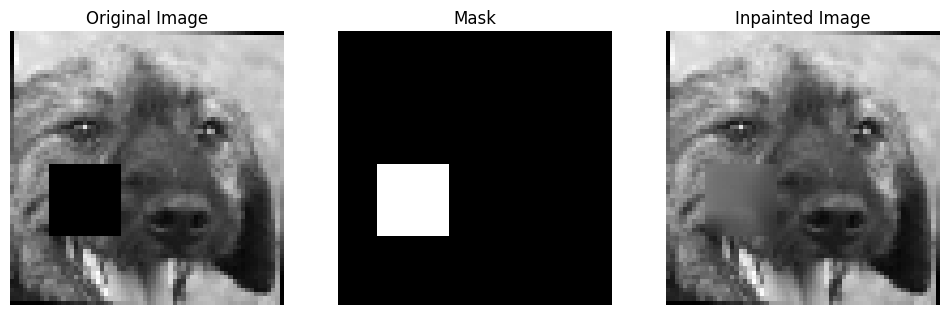

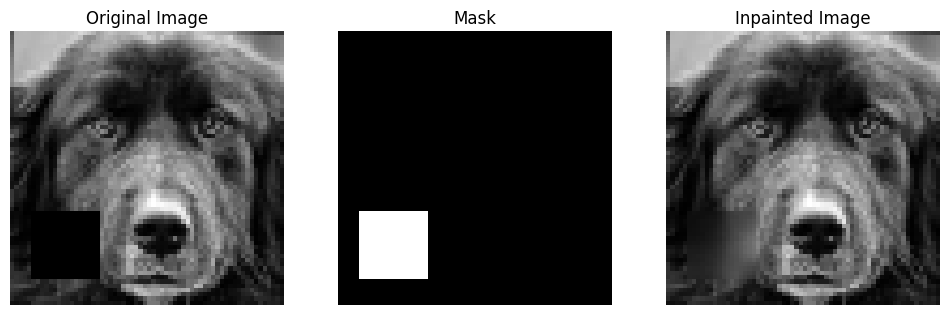

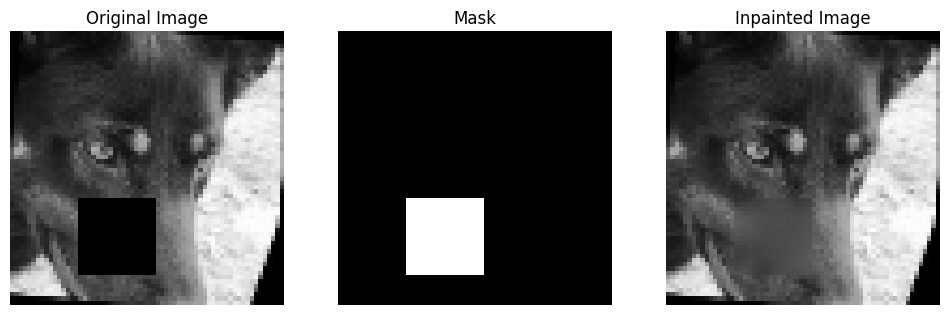

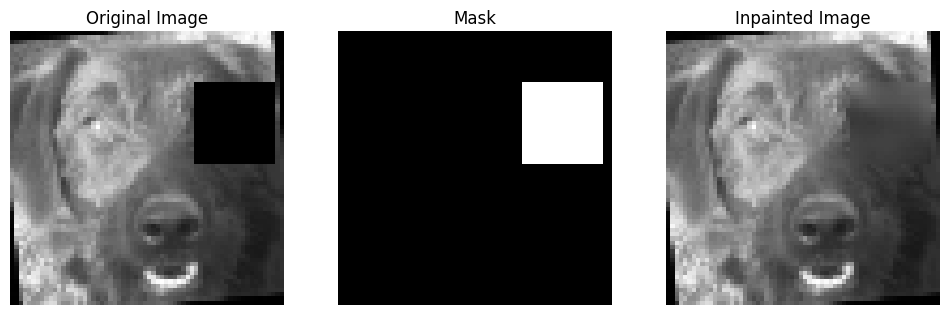

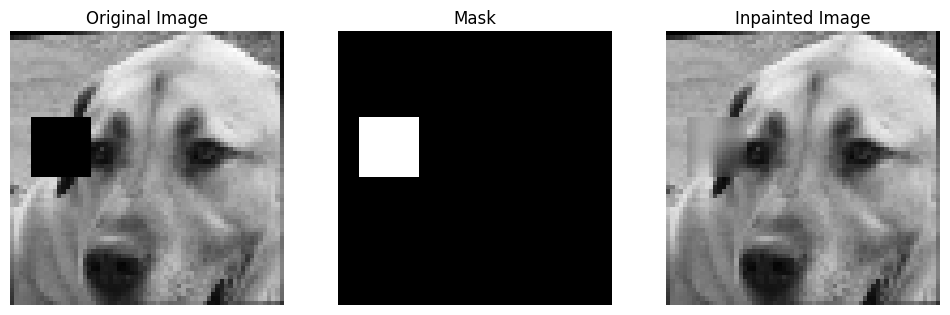

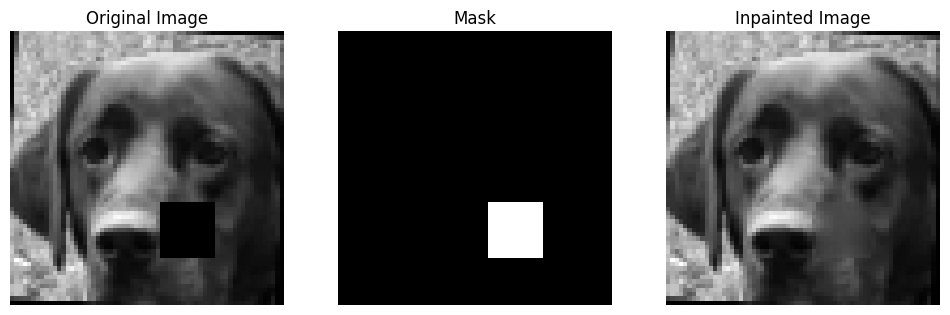

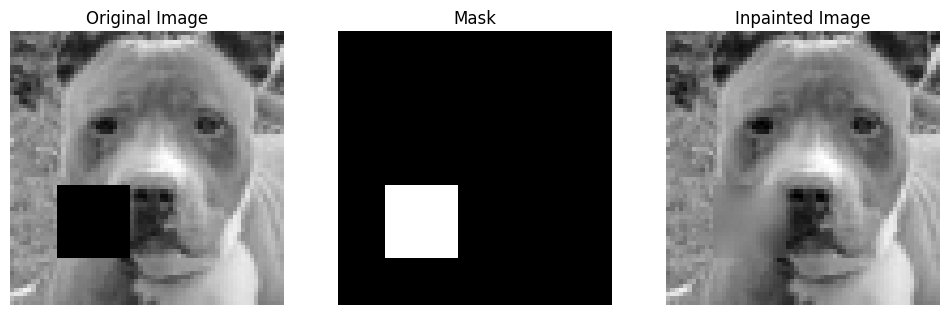

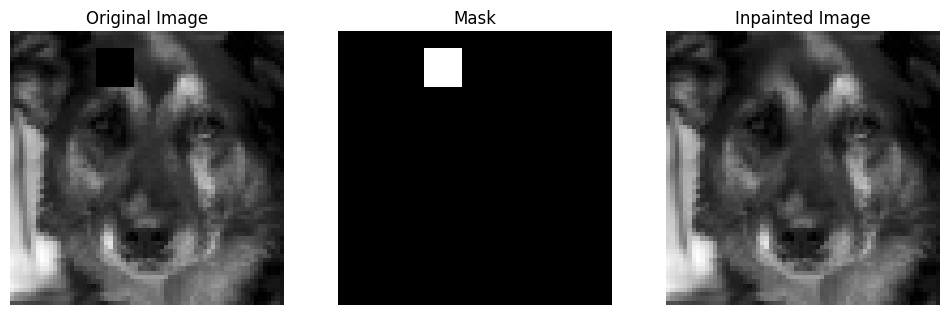

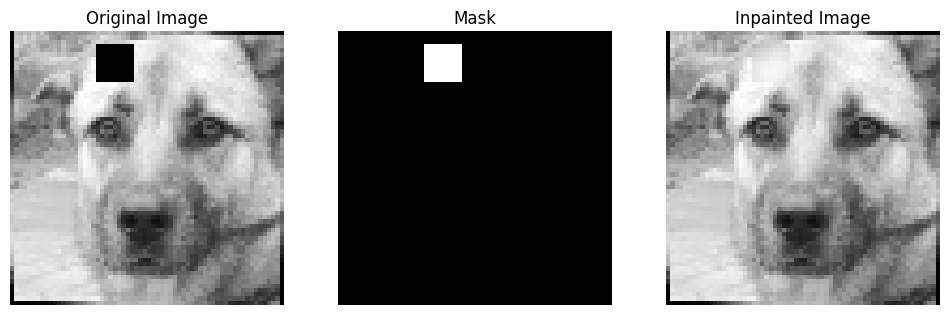

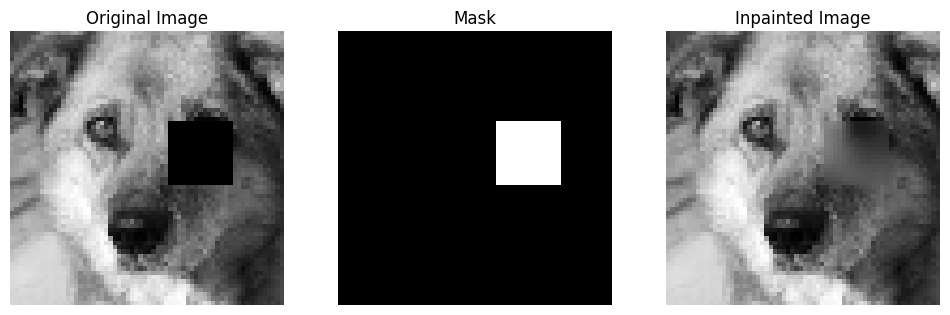

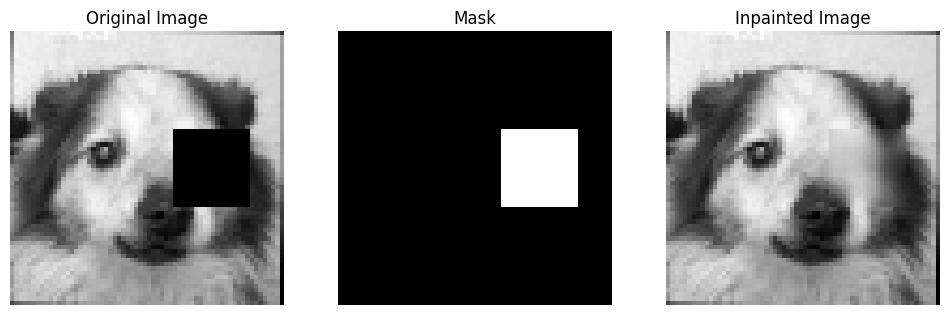

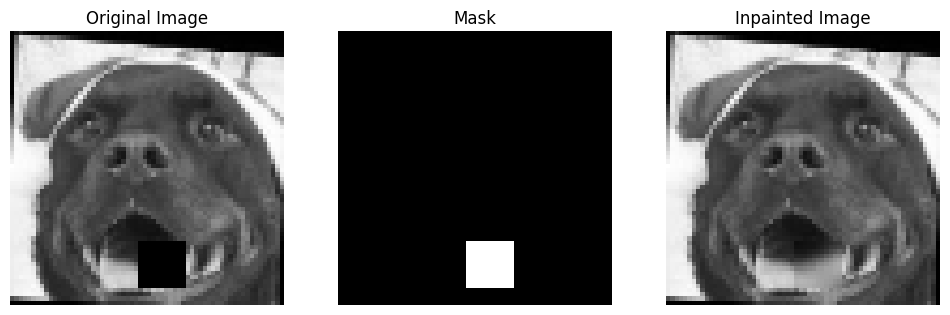

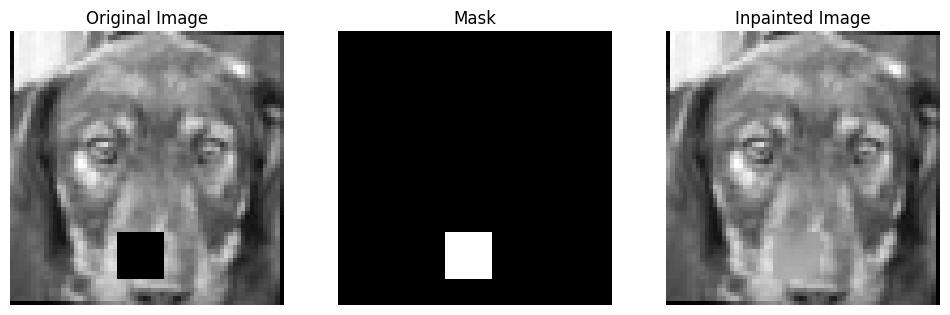

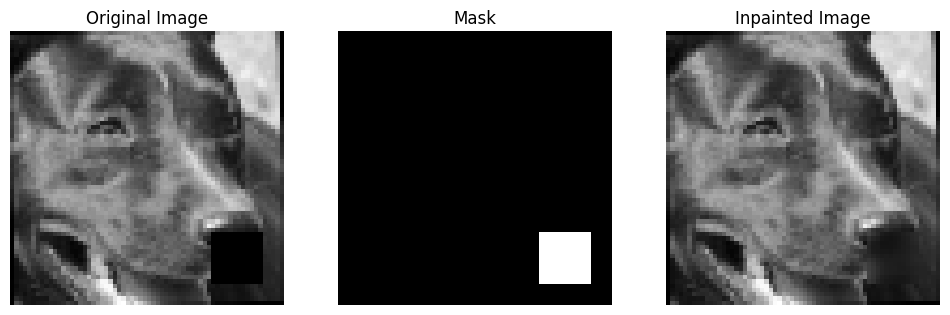

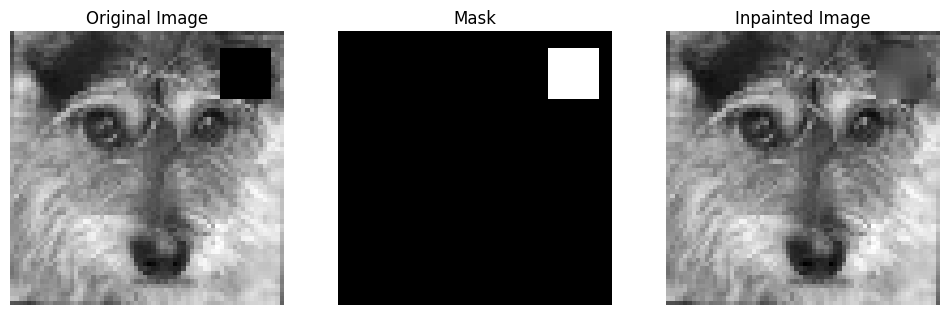

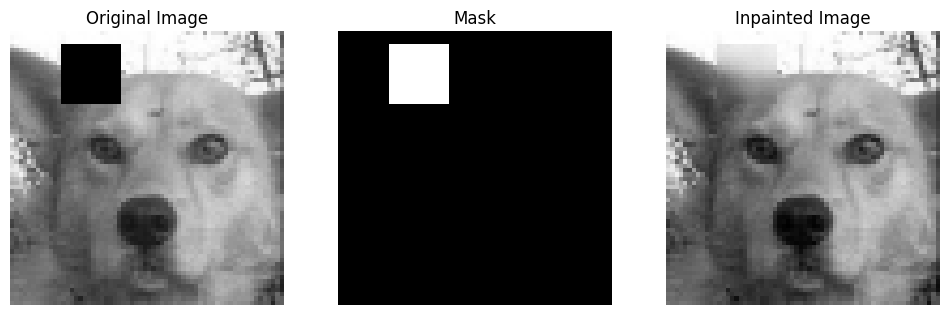

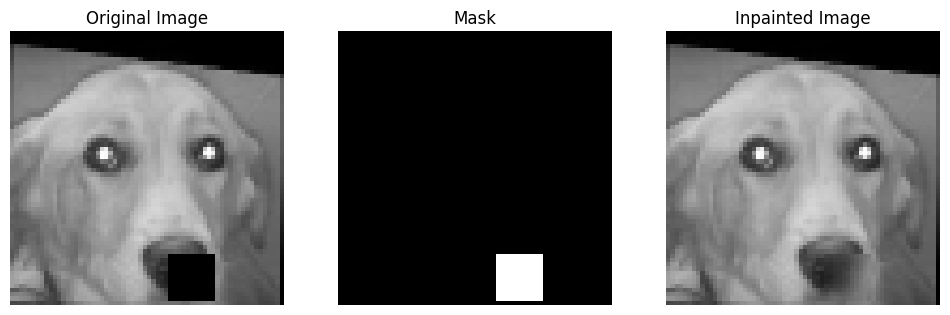

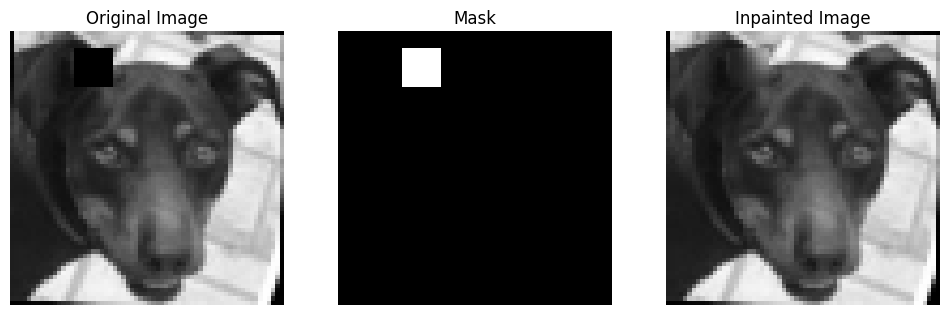

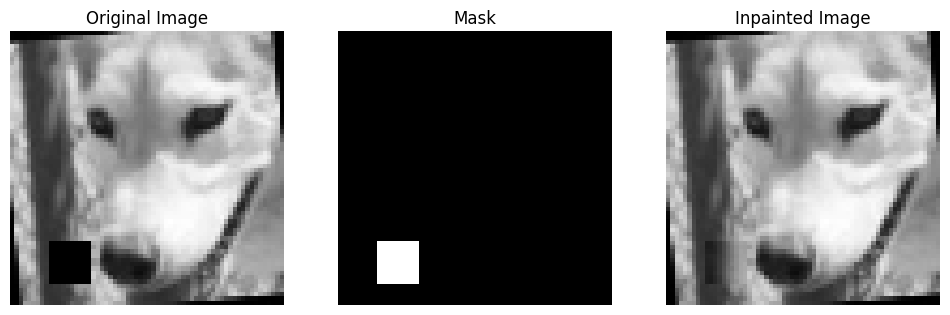

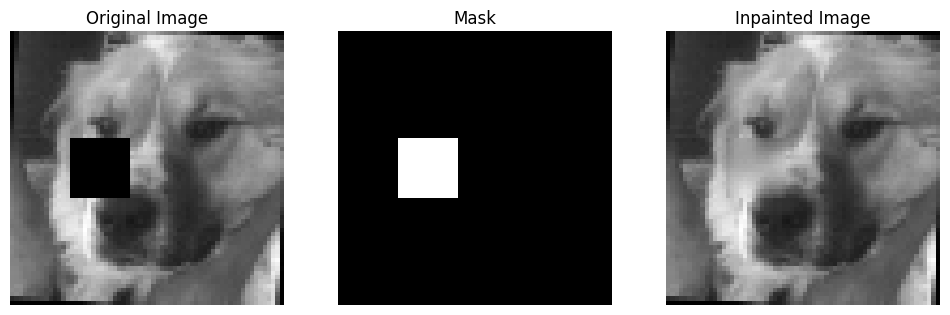

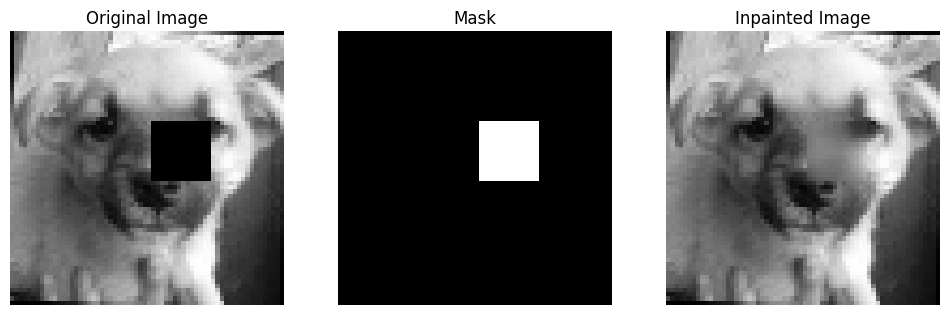

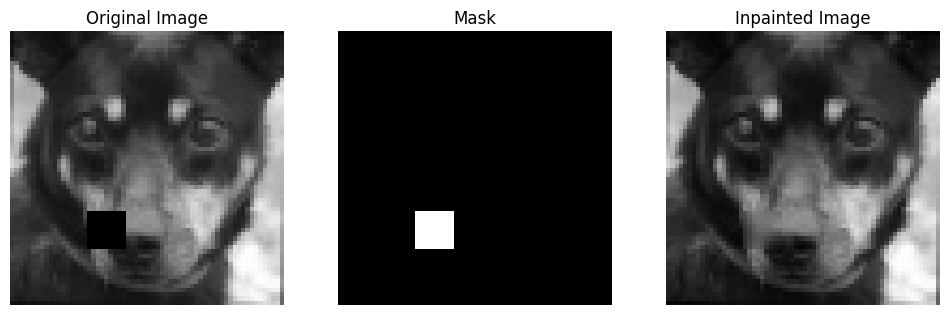

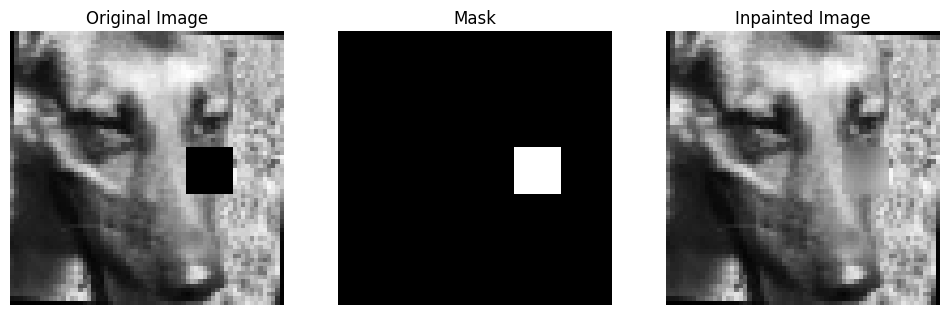

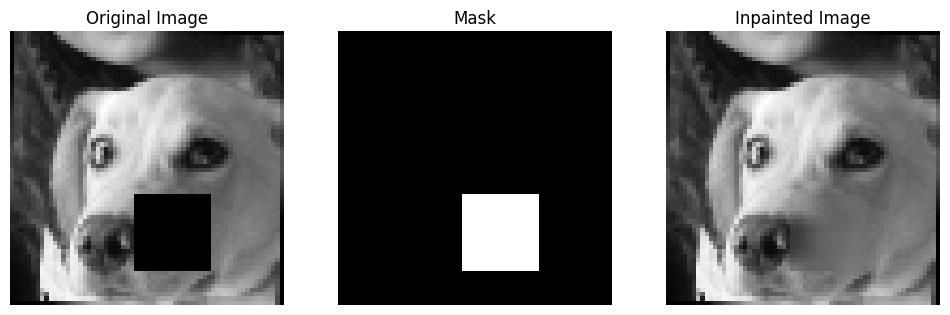

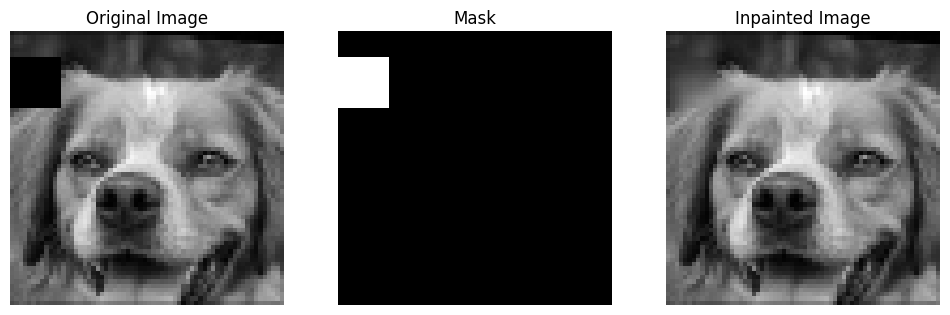

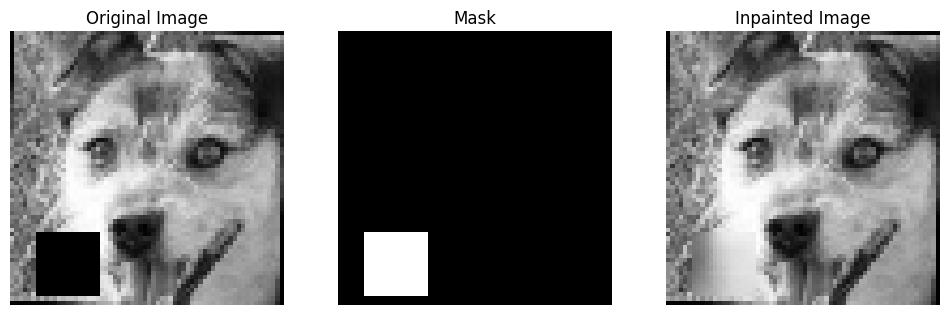

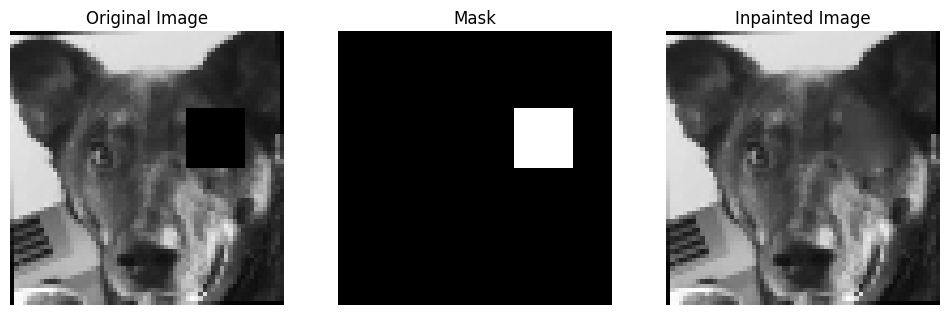

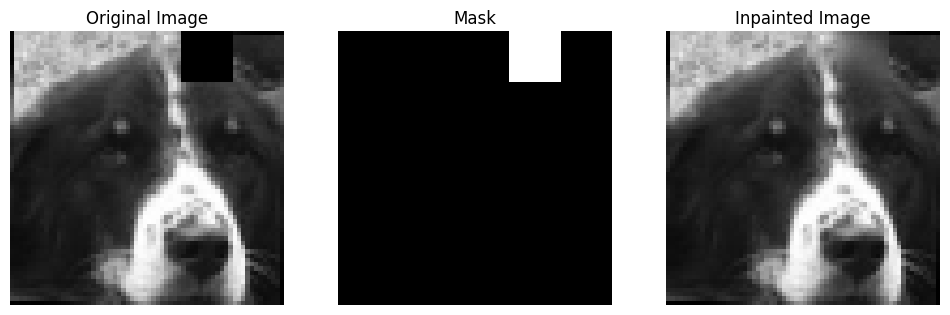

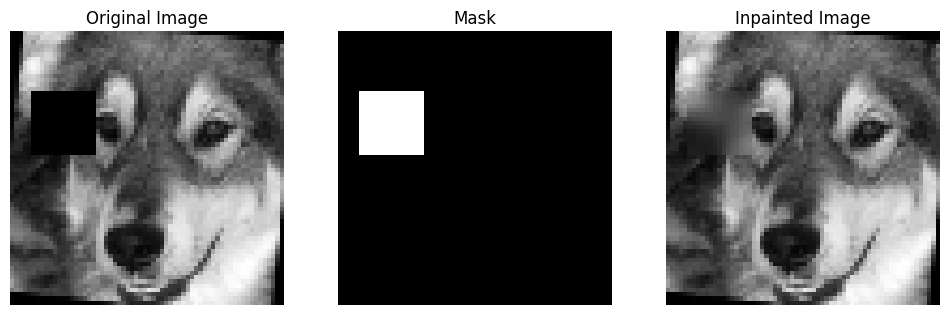

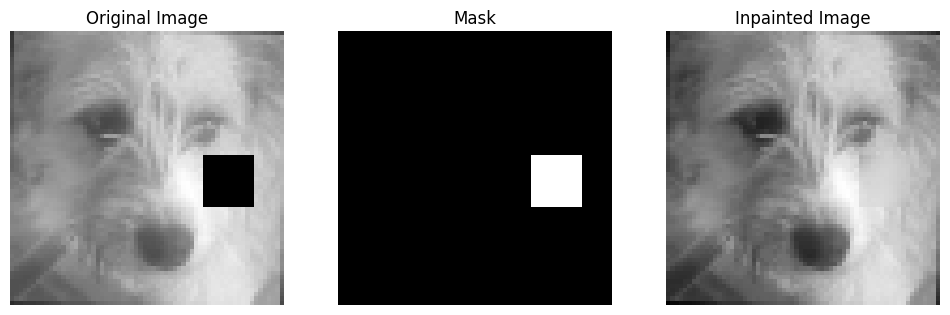

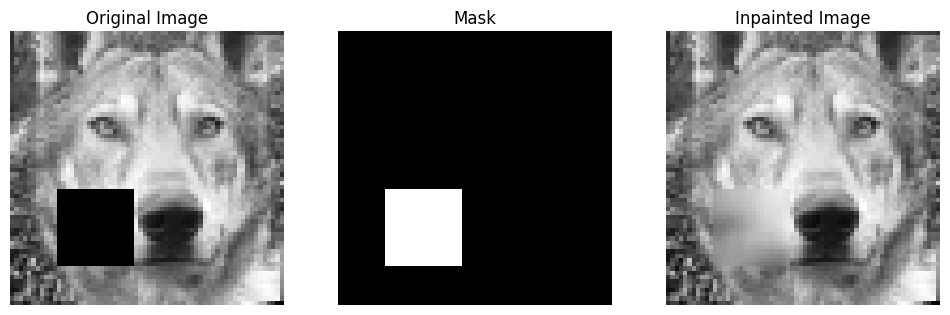

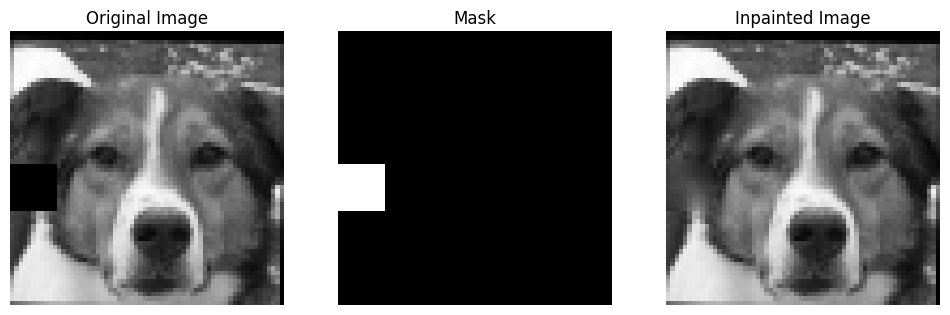

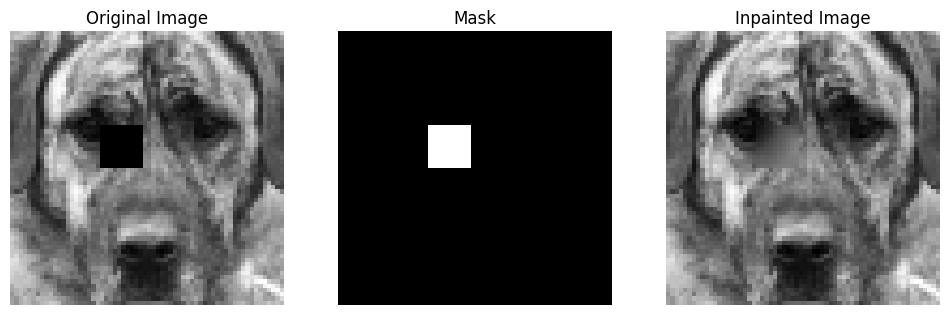

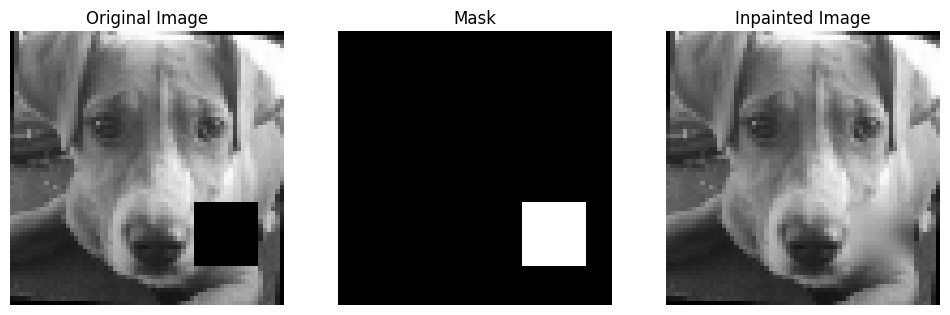

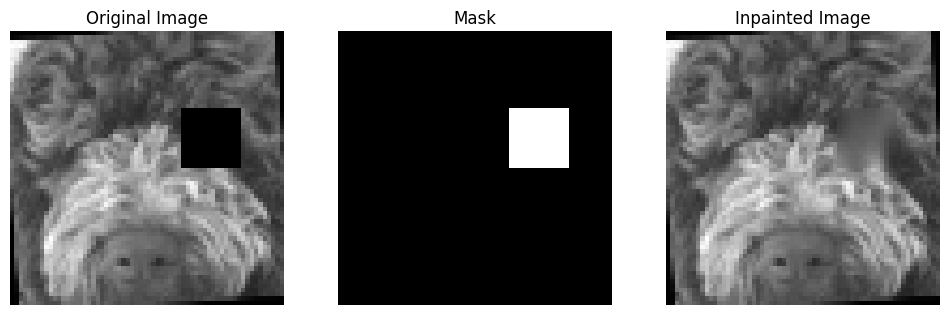

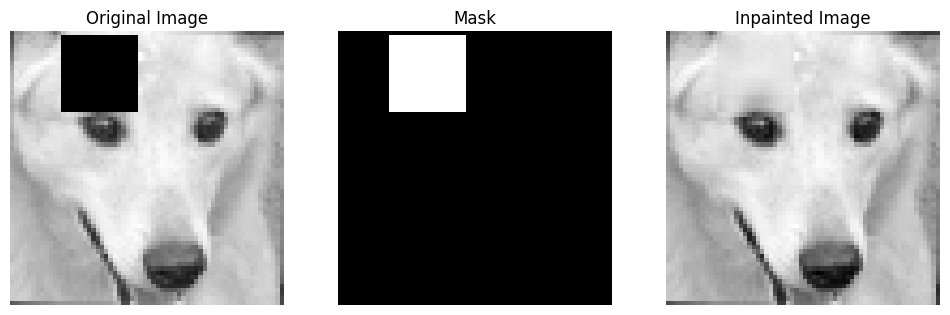

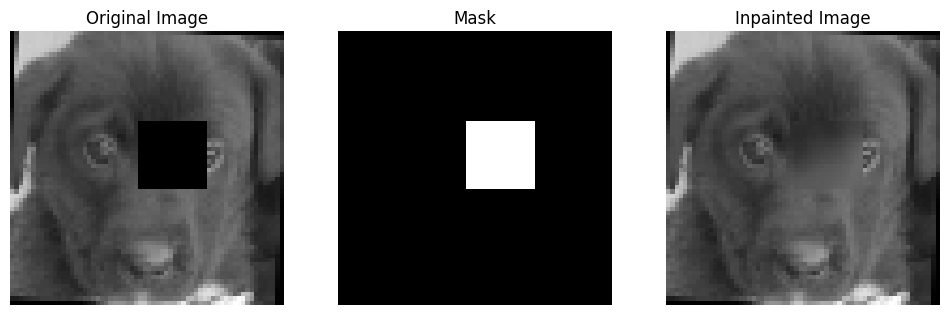

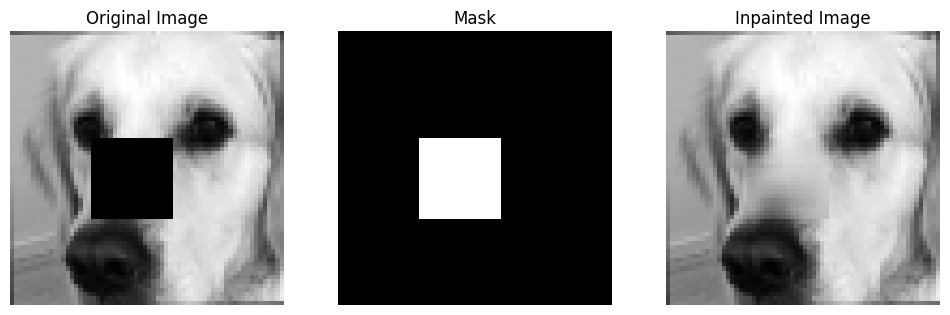

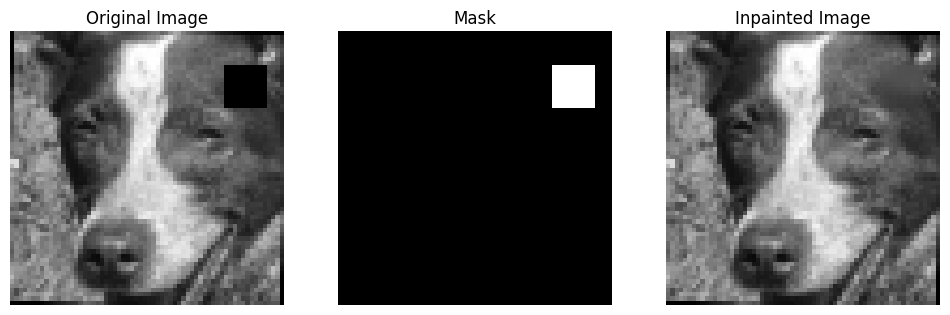

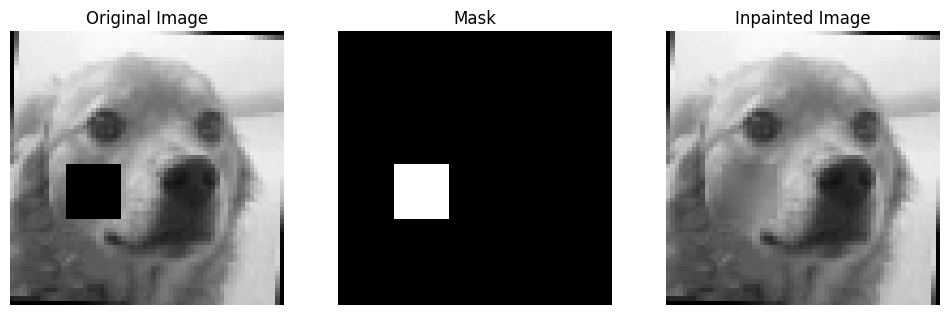

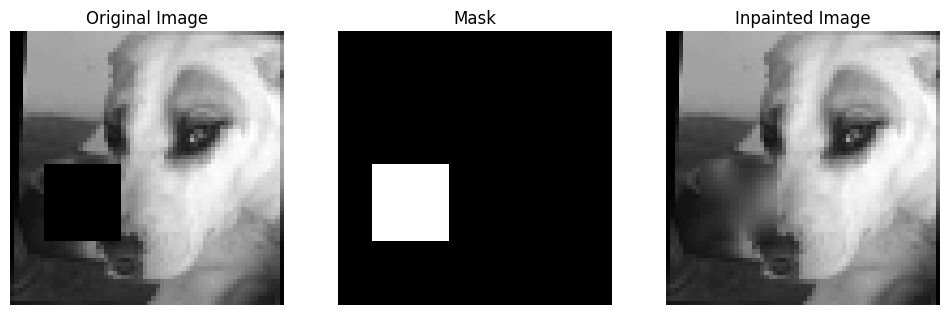

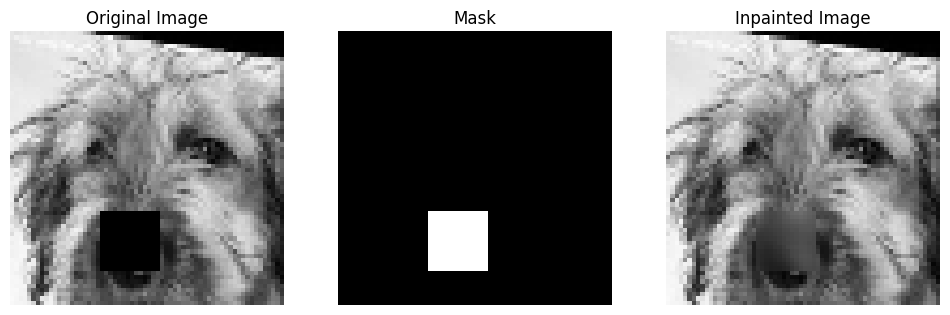

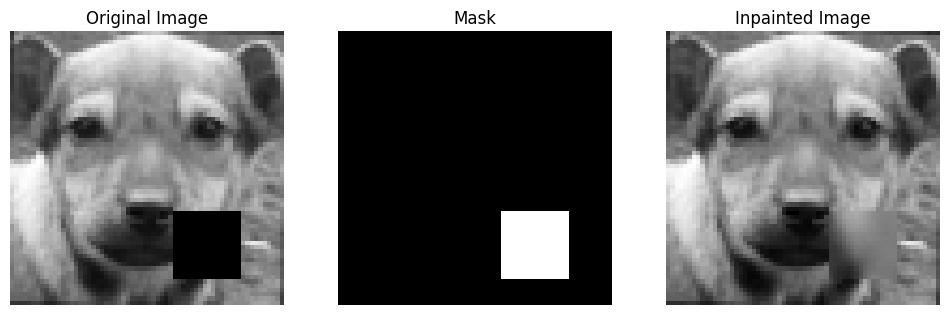

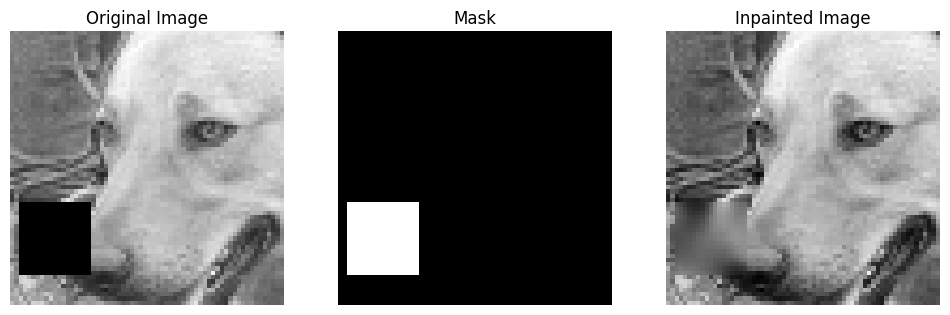

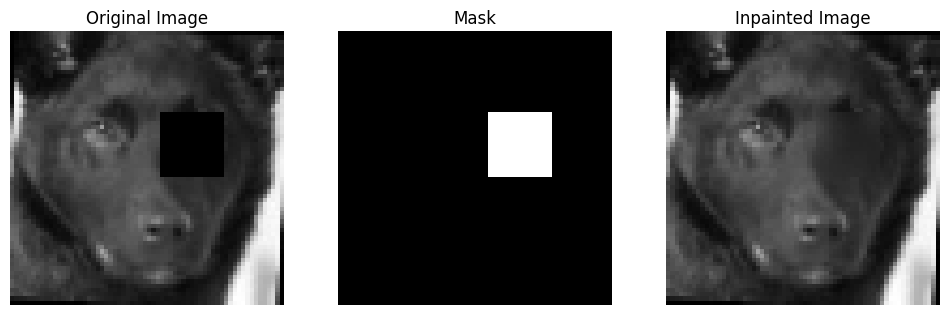

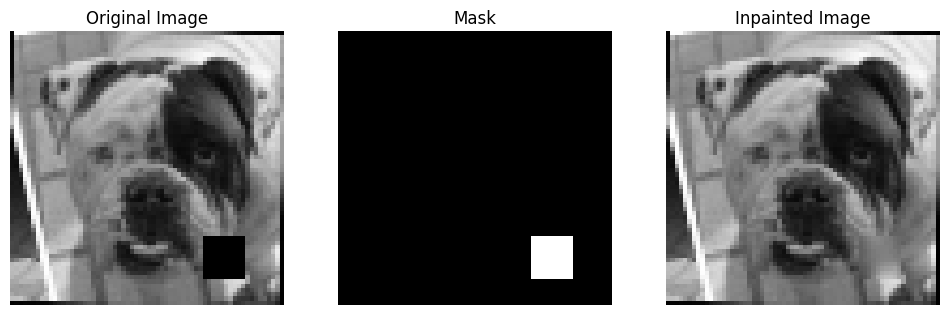

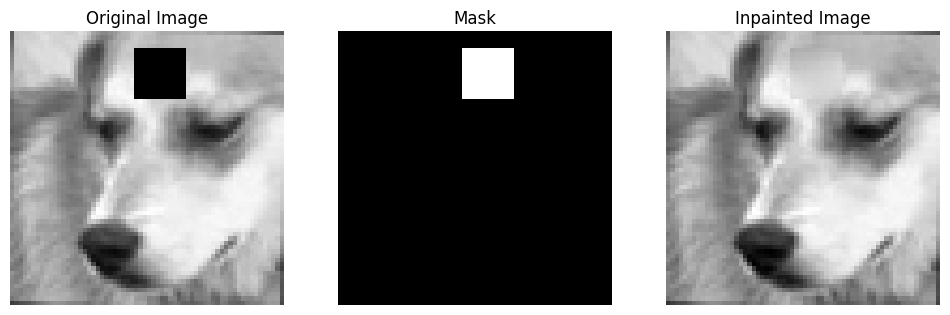

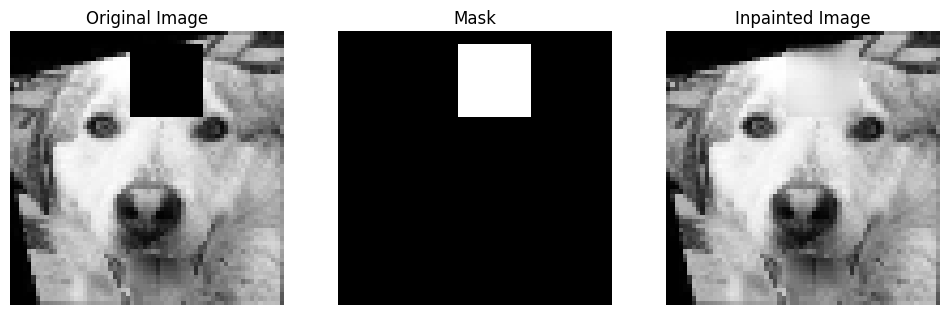

In [9]:
for idx, (test_image, _, test_mask) in enumerate(test_loader):
    inpainted_result = inpaint_image(model, test_image.squeeze(), test_mask)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(test_image.squeeze().numpy(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(test_mask.squeeze().numpy(), cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(inpainted_result.squeeze().numpy(), cmap='gray')
    plt.title('Inpainted Image')
    plt.axis('off')

    plt.show()

## Wizualizacja przykładów

In [54]:
class EvalDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_files = []
        self.mask_files = []
        
        for root, _, files in os.walk(image_dir):
            self.image_files.extend([os.path.join(root, f) for f in files if f.endswith('.jpg')])
        for root, _, files in os.walk(mask_dir):
            self.mask_files.extend([os.path.join(root, f) for f in files if f.endswith('.jpg')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):  
        img_path = self.image_files[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (image_size, image_size))
        image = image.astype(np.float32) / 255.0

        mask_path = self.mask_files[idx]
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (image_size, image_size))
        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        mask = mask.astype(np.float32) / 255.0

        masked_image = image * (1 - mask)
        return (
            torch.tensor(masked_image).unsqueeze(0),
            torch.tensor(image).unsqueeze(0),
            torch.tensor(mask).unsqueeze(0)
        )

In [55]:
eval_dataset = EvalDataset(os.path.join("tests_dogs", "images_dogs"), os.path.join("tests_dogs", "masks_dogs"))
eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False)

In [56]:
def inpaint_image2(model, image, mask):
    model.eval()
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        inpainted_image = output.squeeze(0).cpu()
        result = image * (1 - mask) + inpainted_image * mask
        return inpainted_image, result

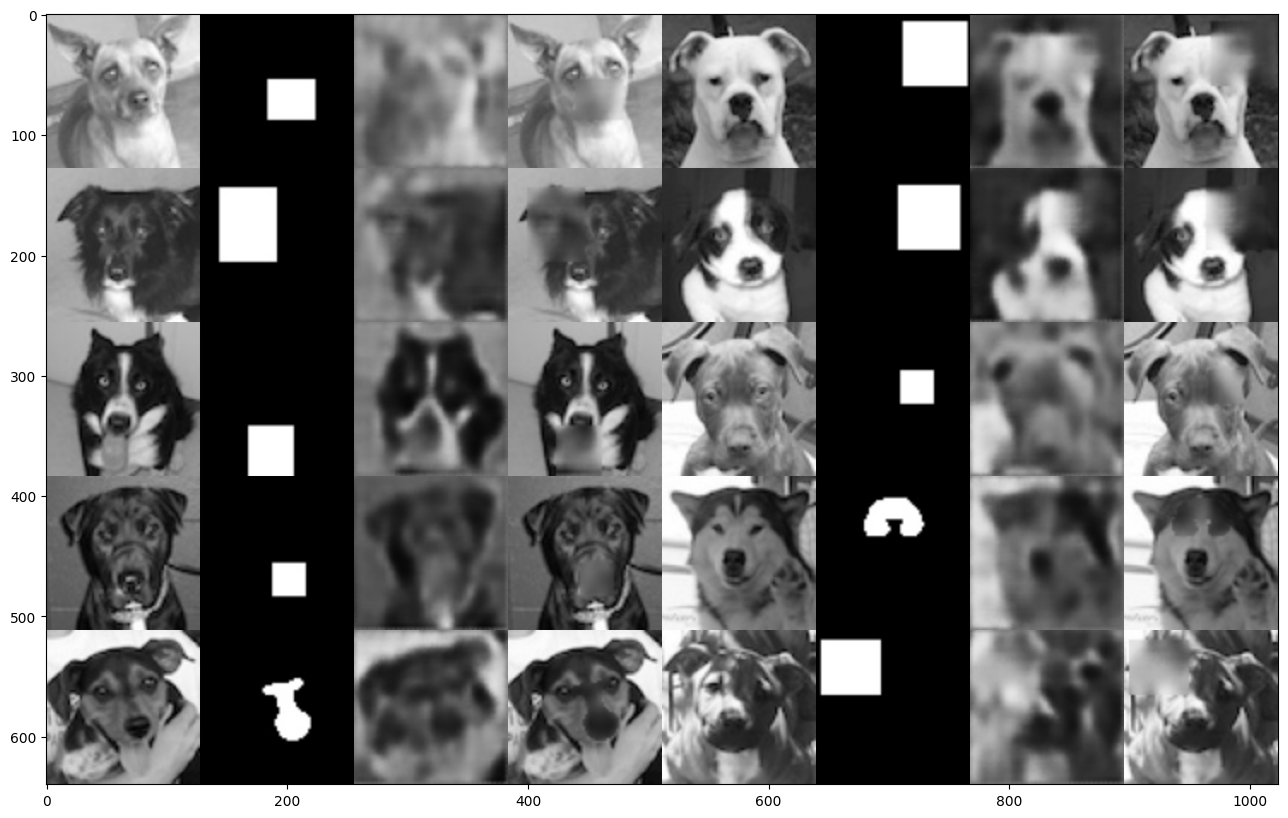

In [57]:
present_size = 128
presentation = np.zeros((present_size*5, present_size*8, 1), dtype=np.float32)

for idx, (masked_raw, raw, mask) in enumerate(eval_loader):
    generated, combined = inpaint_image2(model, masked_raw.squeeze(), mask)
    
    left = (idx % 2) * present_size * 4
    top = (idx // 2) * present_size
    
    presentation[top:top+present_size, left:left+present_size, :] = cv2.resize(raw.squeeze().cpu().numpy(), (present_size, present_size)).reshape((present_size, present_size, 1))
    presentation[top:top+present_size, left+present_size:left+2*present_size, :] = cv2.resize(mask.squeeze().cpu().numpy(), (present_size, present_size)).reshape((present_size, present_size, 1))
    presentation[top:top+present_size, left+2*present_size:left+3*present_size, :] = cv2.resize(generated.squeeze().cpu().numpy(), (present_size, present_size)).reshape((present_size, present_size, 1))
    presentation[top:top+present_size, left+3*present_size:left+4*present_size, :] = cv2.resize(combined.squeeze().cpu().numpy(), (present_size, present_size)).reshape((present_size, present_size, 1))

cv2.imwrite("tests_dogs.jpg", presentation.reshape((present_size*5, present_size*8))*255.)
plt.figure(figsize=(16, 10))
plt.imshow(cv2.imread("tests_dogs.jpg"))
plt.show()